# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import math
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.core.display import display
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation
from official.modeling import tf_utils
from official.nlp.modeling.models.seq2seq_transformer import Seq2SeqTransformer, TransformerDecoder, TransformerEncoder
from official.nlp.modeling.ops import beam_search

In [2]:
from tensorflow.python.keras.metrics import MeanMetricWrapper
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.python.keras import backend
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [5]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [6]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [7]:
if os.getcwd() == "/tf":
    os.chdir(os.path.join('workspace', 'notebooks'))

In [8]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [9]:
# DATA_SOURCE = 'pride'
DATA_SOURCE = 'pdeep'
on_server = True

In [10]:
PROJECT = "PXD010000"

if DATA_SOURCE == 'pride':
    if on_server:
        DUMP_PATH = os.path.join("/scratch/mirko.krause/dumps/", PROJECT)
    else:
        DUMP_PATH = os.path.join("..", "dumps", PROJECT)
    TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
    FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
elif DATA_SOURCE == 'pdeep':
    DUMP_PATH = "/scratch/mirko.krause/pdeep"
    TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
    FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "file_*.parquet")
else:
    assert False

In [11]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/pdeep


In [12]:
SEQ = 'peptide_sequence'

In [13]:
logger = log.create_logger(
    name='mmproteo_attention_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-10-27 14:24:28,485 - mmproteo_attention_model: Logging to file '/scratch/mirko.krause/pdeep/mmproteo_attention_model.log' and to stderr


In [14]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 89,
  'intensity_array': 89,
  'peptide_sequence': 30},
 'idx_to_char': {'2': 'A',
  '3': 'C',
  '4': 'D',
  '5': 'E',
  '6': 'F',
  '7': 'G',
  '8': 'H',
  '9': 'I',
  '10': 'K',
  '11': 'L',
  '12': 'M',
  '13': 'N',
  '14': 'P',
  '15': 'Q',
  '16': 'R',
  '17': 'S',
  '18': 'T',
  '19': 'V',
  '20': 'W',
  '21': 'Y',
  '0': '_',
  '1': 'EOS'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f01b581c160>'},
 'split_value_columns': None,
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(89,), dtype=tf.float64, name=None)), (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))',
 'eos_idx': 1}

In [15]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [16]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-1

In [17]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
#idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [18]:
KEEP_CACHE = False

In [19]:
BATCH_SIZE = 512

In [20]:
TRAIN_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [21]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*.parquet',  # filename
        *(['*' for _ in PROCESSING_INFO['split_value_columns'] or []])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAIN_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 20
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_7.parquet
#Test = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_24.parquet
#Eval = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_11.parquet


2021-10-27 14:24:28,510 - mmproteo_attention_model: DEBUG: assigned values:
2021-10-27 14:24:28,510 - mmproteo_attention_model: DEBUG: #Train = 20
2021-10-27 14:24:28,510 - mmproteo_attention_model: DEBUG: e.g.: file_7.parquet
2021-10-27 14:24:28,510 - mmproteo_attention_model: DEBUG: #Test = 3
2021-10-27 14:24:28,511 - mmproteo_attention_model: DEBUG: e.g.: file_24.parquet
2021-10-27 14:24:28,511 - mmproteo_attention_model: DEBUG: #Eval = 3
2021-10-27 14:24:28,511 - mmproteo_attention_model: DEBUG: e.g.: file_11.parquet
2021-10-27 14:24:28,511 - mmproteo_attention_model: DEBUG: assigned paths:
2021-10-27 14:24:28,511 - mmproteo_attention_model: DEBUG: #Train = 20
2021-10-27 14:24:28,512 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_7.parquet
2021-10-27 14:24:28,512 - mmproteo_attention_model: DEBUG: #Test = 3
2021-10-27 14:24:28,512 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets

### Loading corresponding TF datasets

In [22]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(89,), dtype=tf.float64, name=None),
  TensorSpec(shape=(89,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))

**In the following step, Tensorflow starts allocating a GPU**

In [23]:
# initialize Tensorflow (might take several minutes (~5 minutes per GPU with 40GB VRAM each))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-10-27 14:24:28,520 - mmproteo_attention_model: DEBUG: started initializing tensorflow by creating a first dataset
2021-10-27 14:27:42,761 - mmproteo_attention_model: finished initializing tensorflow


In [24]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [25]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-10-27 14:27:42,774 - mmproteo_attention_model: DEBUG: preparing dataset 'Train' with 20 paths
2021-10-27 14:27:42,776 - mmproteo_attention_model: DEBUG: applied options to dataset 'Train'
2021-10-27 14:27:42,822 - mmproteo_attention_model: DEBUG: loaded dataset 'Train' interleaved
2021-10-27 14:27:42,823 - mmproteo_attention_model: DEBUG: skipped caching dataset 'Train'
2021-10-27 14:27:42,823 - mmproteo_attention_model: DEBUG: shuffled dataset 'Train'
2021-10-27 14:27:42,824 - mmproteo_attention_model: DEBUG: batched dataset 'Train'
2021-10-27 14:27:42,824 - mmproteo_attention_model: DEBUG: configured prefetching for dataset 'Train'
2021-10-27 14:27:42,824 - mmproteo_attention_model: DEBUG: skipped benchmarking dataset 'Train'
2021-10-27 14:27:42,824 - mmproteo_attention_model: prepared dataset 'Train'
2021-10-27 14:27:42,825 - mmproteo_attention_model: DEBUG: preparing dataset 'Test' with 3 paths
2021-10-27 14:27:42,825 - mmproteo_attention_model: DEBUG: applied options to datas

{'Train': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>}

In [26]:
original_datasets = datasets

In [27]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = -1) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype),
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ),
            tensor
        ],
        axis=1
    )


def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]) \
-> Tuple[Dict[str, tf.data.Dataset], tf.data.Dataset]:
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)
    targets = prefix_target_sequences_with_start_token(targets[0])
    targets = tf.cast(
        x=targets,
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets[:, :-1],
        },
        targets[:, 1:]
    )


def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [28]:
# use these methods if the model shifts the target input itself

def _dataset_mapper_for_transformer_unshifted(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]) \
-> Tuple[Dict[str, tf.data.Dataset], tf.data.Dataset]:
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)

    targets = tf.cast(
        x=targets[0],
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets,
        },
        targets
    )

def prepare_dataset_for_transformer_training_unshifted(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer_unshifted)

In [29]:
datasets = {
    t: prepare_dataset_for_transformer_training_unshifted(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Test': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Eval': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>}

## Building the Tensorflow Model

In [30]:
# taken from: https://github.com/tensorflow/models/blob/027813d334645d6076a72b41b7b87ec30334cbb1/official/nlp/modeling/layers/position_embedding.py#L91
def embed_with_sin_and_cos(positions: Union[tf.Tensor, np.ndarray], embedding_width: int) -> tf.Tensor:
    """
    positions: a tensor with the dimensions [batch_size, item count]
    """
    # constants
    num_timescales = embedding_width // 2
    min_timescale, max_timescale = 1.0, 1.0e4
    log_timescale_increment = (
        math.log(float(max_timescale) / float(min_timescale)) /
        (tf.cast(num_timescales, tf.float32) - 1))
    inv_timescales = min_timescale * tf.exp(
        tf.cast(tf.range(num_timescales), tf.float32) *
        -log_timescale_increment)

    # calculations
    scaled_time = tf.expand_dims(positions, -1) * tf.expand_dims(
        inv_timescales, 0)
    position_embeddings = tf.concat(
        [tf.sin(scaled_time), tf.cos(scaled_time)], axis=-1)
    return position_embeddings

In [31]:
char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]]

0

In [32]:
# heavily based on:
# https://github.com/tensorflow/models/blob/master/official/nlp/modeling/models/seq2seq_transformer.py
# (29.06.2021)
class MyTransformer(Seq2SeqTransformer):
    _eos_id: int = char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]]
        
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        mz = sources[:, :, 0]
        intensities = sources[:, :, 1]
        targets = inputs.get("targets", None)
        
        # Prepare inputs to the layer stack by adding positional encodings and applying dropout.

        embedded_mz = embed_with_sin_and_cos(mz, self._embedding_width)
        embedded_intensities = embedded_mz * tf.expand_dims(intensities, -1)
    
        sources = embedded_intensities
        
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=3)
        batch_size = input_shape[0]
        input_length = input_shape[1]
        channel_count = input_shape[2]
        non_padding_sources = tf.not_equal(mz, 0.0)
        non_padding_sources = tf.reshape(
            tensor=non_padding_sources,
            shape=[batch_size, 1, input_length]
        )
        attention_mask = tf.cast(
            x=non_padding_sources,
            dtype=sources.dtype
        )
        broadcast_ones = tf.ones(
            shape=[batch_size, input_length, 1],
            dtype=sources.dtype
        )
        attention_mask = broadcast_ones * attention_mask

        encoder_inputs = self.encoder_dropout(sources)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)
        
        if targets is None:
            if self._padded_decode:
                max_decode_length = self._decode_max_length
            else:
                max_decode_length = self._decode_max_length or (
                        tf.shape(encoder_outputs)[1] + self._extra_decode_length)
            symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

            #batch_size = tf.shape(encoder_outputs)[0]
            # Create initial set of IDs that will be passed to symbols_to_logits_fn.
            initial_ids = tf.zeros([batch_size], dtype=tf.int32)

            # Create cache storing decoder attention values for each layer.
            init_decode_length = (max_decode_length if self._padded_decode else 0)
            num_heads = self.decoder_layer.num_attention_heads
            dim_per_head = self._embedding_width // num_heads

            # Cache dtype needs to match beam_search dtype.
            # pylint: disable=g-complex-comprehension
            cache = {
                str(layer): {
                    "key":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype),
                    "value":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype)
                } for layer in range(self.decoder_layer.num_layers)
            }
            # pylint: enable=g-complex-comprehension

            # Add encoder output and attention bias to the cache.
            encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
            
            #attention_mask = tf.cast(
            #    tf.reshape(
            #        tf.not_equal(sources, 0), [batch_size, 1, input_length]),
            #    dtype=self.compute_dtype)
            attention_mask = tf.cast(
                    tf.not_equal(sources, 0),
                dtype=self.compute_dtype)
            cache["encoder_outputs"] = encoder_outputs
            cache["encoder_decoder_attention_mask"] = attention_mask
            
            search_parameters = {
                "initial_ids": initial_ids,
                "initial_cache": cache,
                "vocab_size": self._vocab_size,
                "beam_size": self._beam_size,
                "alpha": self._alpha,
                "max_decode_length": max_decode_length,
                "eos_id": self._eos_id,
                "padded_decode": self._padded_decode
            }
            #return search_parameters
        
            # Use beam search to find the top beam_size sequences and scores.
            decoded_ids, scores = beam_search.sequence_beam_search(
                symbols_to_logits_fn=symbols_to_logits_fn,
                initial_ids=initial_ids,
                initial_cache=cache,
                vocab_size=self._vocab_size,
                beam_size=self._beam_size,
                alpha=self._alpha,
                max_decode_length=max_decode_length,
                eos_id=self._eos_id,
                padded_decode=self._padded_decode,
                dtype=self.compute_dtype)

            # Get the top sequence for each batch element
            top_decoded_ids = decoded_ids[:, 0, 1:]
            top_scores = scores[:, 0]

            return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        # seems smarter than the dataset approach
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, decoder_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources[:, :, 0], 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            memory_mask=self_attention_mask,
            target_mask=attention_mask)
        
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits

In [33]:
def jaccard_distance(elem):
    i_true, i_pred = elem[0], elem[1]
    unique_true, _ = tf.unique(i_true)
    unique_pred, _ = tf.unique(i_pred)
    n_unique_true = tf.shape(unique_true)[0]
    n_unique_pred = tf.shape(unique_pred)[0]
    unique_all, _ = tf.unique(tf.concat(values=[unique_true, unique_pred], axis=-1))
    n_unique_all = tf.shape(unique_all)[0]
    n_overlap = n_unique_true + n_unique_pred - n_unique_all
    return n_overlap / n_unique_all

def jaccard_batch_distance(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
            backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    jaccard = tf.map_fn(fn=jaccard_distance, elems=(y_true, y_pred), fn_output_signature=tf.float64)
    return math_ops.cast(jaccard, backend.floatx())
    

class JaccardBatchDistance(MeanMetricWrapper):
    def __init__(self, name='jaccard_batch_distance', dtype=None):
        super(JaccardBatchDistance, self).__init__(
            jaccard_batch_distance, name, dtype=dtype)

In [34]:
def leuvenshtein_sparse_tensor_batch_distance(y_true: tf.sparse.SparseTensor, y_pred: tf.sparse.SparseTensor) -> tf.Tensor:
    return tf.edit_distance(
        hypothesis=y_pred,
        truth=y_true,
        normalize=False,
    )

def leuvenshtein_batch_distance(y_true: tf.Tensor, y_pred: tf.Tensor, sparse_pred: bool = True) -> tf.Tensor:
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    
    if sparse_pred:
        y_pred = math_ops.argmax(y_pred, axis=-1)
    
    y_pred = tf.sparse.from_dense(y_pred)
    y_true = tf.sparse.from_dense(y_true)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    # 0th dimension is the batch
    leuvenshtein = leuvenshtein_sparse_tensor_batch_distance(y_true, y_pred)
    return math_ops.cast(leuvenshtein, backend.floatx())
    

class LeuvenshteinBatchDistance(MeanMetricWrapper):
    def __init__(self, name='leuvenshtein_batch_distance', dtype=None):
        super(LeuvenshteinBatchDistance, self).__init__(
            leuvenshtein_batch_distance, name, dtype=dtype)

In [35]:
# copied from https://github.com/tensorflow/tensorflow/blob/v2.6.0/tensorflow/python/keras/metrics.py

def sparse_categorical_accuracy(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = ops.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    # If the shape of y_true is (num_samples, 1), squeeze to (num_samples,)
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(
        backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)

    # If the predicted output and actual output types don't match, force cast them
    # to match.
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))

    return math_ops.cast(math_ops.equal(y_true, y_pred), backend.floatx())

class SparseCategoricalAccuracy(MeanMetricWrapper):
    def __init__(self, name='sparse_categorical_accuracy', dtype=None):
        super(SparseCategoricalAccuracy, self).__init__(
            sparse_categorical_accuracy, name, dtype=dtype)

In [36]:
TRANSFORMER_LAYERS = 6
ATTENTION_HEADS = 16
EMBEDDING_WIDTH = 512  # d_model
LEARNING_RATE = 10**-5

In [37]:
def build_model() -> tf.keras.Model:
    encoder_layer = TransformerEncoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )
    decoder_layer = TransformerDecoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )

    model = MyTransformer(
        vocab_size=len(idx_to_char),
        embedding_width=EMBEDDING_WIDTH,
        encoder_layer=encoder_layer,
        decoder_layer=decoder_layer,
        name=f"mmproteo_transformer_{utils.get_current_time_str()}",
        decode_max_length=PROCESSING_INFO['padding_lengths'][SEQ],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=LEARNING_RATE,
            beta_2=0.98,  # values taken from the 'Attention is all you need' paper
            epsilon=10**-9,
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #masked_loss,
        metrics=[
            SparseCategoricalAccuracy(),
            JaccardBatchDistance(),
            LeuvenshteinBatchDistance(),
        ]
    )
    return model

In [38]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [39]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")

In [40]:
def create_model() -> tf.keras.Model:
    with mirrored_strategy.scope():
        model = build_model()
    global MODEL_PATH
    MODEL_PATH = os.path.join(MODELS_PATH, model.name)
    utils.ensure_dir_exists(MODEL_PATH)
    logger.info(f"created new model '{model.name}'")
    return model

In [41]:
model = create_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2021-10-27 14:27:43,334 - mmproteo_attention_model: created new model 'mmproteo_transformer_20211027-142742'


In [42]:
logger.debug("started a first prediction")
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

2021-10-27 14:27:43,338 - mmproteo_attention_model: DEBUG: started a first prediction


array([[[ 2.60377228e-01,  2.52109575e+00, -7.51939416e-01,
          2.61526752e+00,  1.07287288e+00, -1.57952023e+00,
          8.78746152e-01, -1.08122075e+00, -6.30190790e-01,
         -3.62528265e-01,  6.00876100e-02,  3.92635912e-01,
         -6.78080678e-01,  8.63822341e-01,  5.65050542e-01,
          5.32669306e-01, -2.04448447e-01, -5.74154198e-01,
          1.05860436e+00,  1.18807697e+00,  9.55575779e-02,
          1.33618712e+00],
        [-4.49909866e-01,  2.07517886e+00, -6.70637012e-01,
          1.92726338e+00,  7.95788646e-01, -1.43821609e+00,
          1.20233655e+00, -8.00189972e-01, -5.36046088e-01,
         -1.57500789e-01, -5.77222347e-01, -3.38198245e-01,
         -1.07707953e+00,  8.40780735e-01,  1.11978805e+00,
          3.07505459e-01, -2.50193328e-01, -5.46843648e-01,
          9.27609324e-01,  6.59526682e+00, -4.49559212e-01,
          1.32921314e+00],
        [ 6.09669924e-01,  1.67681742e+00, -8.89184475e-01,
          2.12824678e+00,  1.27225292e+00, -1.

In [43]:
logger.info("finished a first prediction - Tensorflow should be ready now")

2021-10-27 14:29:19,924 - mmproteo_attention_model: finished a first prediction - Tensorflow should be ready now


In [44]:
MODEL_PATH

'/scratch/mirko.krause/pdeep/models/mmproteo_transformer_20211027-142742'

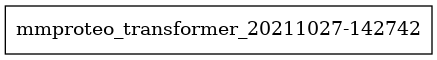

In [45]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True,
    expand_nested=True,
)

In [46]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_transformer_20211027-142742"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding (OnDevic multiple                  11264     
_________________________________________________________________
transformer_encoder (Transfo multiple                  18903040  
_________________________________________________________________
transformer_decoder (Transfo multiple                  25200640  
_________________________________________________________________
relative_position_embedding  multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
Total params: 44,114,944
Trainable params: 44,114,944
Non-trainable params: 0
__________________

In [47]:
try:
    with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
        file.write(model.to_json())

    with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
        file.write(model.to_yaml())
except NotImplementedError as e:
    print("not implemented")

not implemented


## Training the Tensorflow Model

In [48]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.98,
 'epsilon': 1e-09,
 'amsgrad': False}

In [49]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

eval_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

train_evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[TRAIN_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [50]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=False,
            csv=True,
            base_path=MODEL_PATH,
)

In [51]:
WARMUP_STEPS = 3000
STEPS_PER_EPOCH = 200

In [ ]:
last_model = None

learning_rate = 10**-6
slowing_factor = 1

first_epoch = 1

while True:
    error_count = 0
    training_dataset = datasets[TRAIN_TYPE].repeat()
    validation_dataset = datasets[TEST_TYPE].repeat()
    
    aborted = False
    
    for epoch in range(first_epoch, 100):
        logger.info(f"epoch {epoch}:")
        learning_rate = EMBEDDING_WIDTH**-0.5 * min((epoch * STEPS_PER_EPOCH)**-0.5, (epoch * STEPS_PER_EPOCH) * WARMUP_STEPS**-1.5) / slowing_factor
        tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
        logger.debug(str(model.optimizer.get_config()))

        try:
            history = model.fit(
                x=training_dataset,
                validation_data=validation_dataset,
                validation_steps=STEPS_PER_EPOCH//5,
                epochs=epoch,
                steps_per_epoch=STEPS_PER_EPOCH,
                callbacks=callback_list,
                initial_epoch=epoch-1,
            )
            logger.debug(str(history.history))
        except tf.errors.InvalidArgumentError as e:
            logger.warning(f"Training error: {e}")
            error_count += 1
            if error_count > 10:
                logger.warning("abort training, because of too many NaN loss results")
                break

        print("Train:")
        eval_df, (x_eval, y_eval, y_pred) = train_evaluator.evaluate_model_visually(
            model=model,
            sample_size=5,
            keep_separator=True,
        )
        display(eval_df)
        
        print("Eval:")
        eval_df, (x_eval, y_eval, y_pred) = eval_evaluator.evaluate_model_visually(
            model=model,
            sample_size=5,
            keep_separator=True,
        )
        display(eval_df)
        
    else:
        aborted = True
    
    if not aborted:
        break
    
    last_model = model
    model = create_model()
    learning_rate *= 0.5
    slowing_factor *= 2
    first_epoch = 1
    break

2021-10-27 14:29:20,245 - mmproteo_attention_model: epoch 1:
2021-10-27 14:29:20,250 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 5.3791435e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


200/200 [==============================] - 419s 2s/step - loss: 2.1322 - sparse_categorical_accuracy: 0.4447 - jaccard_batch_distance: 0.7076 - leuvenshtein_batch_distance: 6.1424 - val_loss: 2.1158 - val_sparse_categorical_accuracy: 0.3703 - val_jaccard_batch_distance: 0.2839 - val_leuvenshtein_batch_distance: 17.4531


2021-10-27 14:36:21,875 - mmproteo_attention_model: DEBUG: {'loss': [1.7707287073135376], 'sparse_categorical_accuracy': [0.4838222563266754], 'jaccard_batch_distance': [0.6420323848724365], 'leuvenshtein_batch_distance': [7.792597770690918], 'val_loss': [2.115769624710083], 'val_sparse_categorical_accuracy': [0.3702685534954071], 'val_jaccard_batch_distance': [0.28393393754959106], 'val_leuvenshtein_batch_distance': [17.453075408935547]}


Train:


,predicted,true
0,R L L L L L L R R R R R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R H A E G C S T P E L H R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,L L L L L L L L L L L L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I A L N S D V L F D S V L G I N V P V H Q R _ _ _ _ _ _ _ _
2,L L L L L L L K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E A L L K E K L G G D Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,L L G L L L L L L L L L L L L L L L L A R R _ _ _ _ _ _ _ _,Y T L L Y D P L D G S S N L D T N L N V G S I F S V R _ _ _
4,L G L L L L L L L L L L K L L L L L L K K K _ _ _ _ _ _ _ _,N G R P P L P S N Q K R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,L L S S L L L L L L L L L L L L L L L L K _ _ _ _ _ _ _ _ _,T M V R S H V S S C F W L G L P T R _ _ _ _ _ _ _ _ _ _ _ _
1,L S L L L L L L L A L L G L L L L L L A R _ _ _ _ _ _ _ _ _,A H S S M V G V D L P Q K A A G F L V K K _ _ _ _ _ _ _ _ _
2,L L L L A L L K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L V L A I R G E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,R R R R R R R R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E Q E K Q L G F K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L G L A L A L K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,W L A G L V A V G L A A L L L Y L W H A R _ _ _ _ _ _ _ _ _


2021-10-27 14:36:24,826 - mmproteo_attention_model: epoch 2:
2021-10-27 14:36:24,828 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00010758287, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 2/2
200/200 [==============================] - 408s 2s/step - loss: 1.5386 - sparse_categorical_accuracy: 0.5228 - jaccard_batch_distance: 0.3587 - leuvenshtein_batch_distance: 13.4423 - val_loss: 2.0753 - val_sparse_categorical_accuracy: 0.3876 - val_jaccard_batch_distance: 0.3109 - val_leuvenshtein_batch_distance: 17.1797


2021-10-27 14:43:15,895 - mmproteo_attention_model: DEBUG: {'loss': [1.538588523864746], 'sparse_categorical_accuracy': [0.5227978229522705], 'jaccard_batch_distance': [0.35869690775871277], 'leuvenshtein_batch_distance': [13.44229507446289], 'val_loss': [2.0752854347229004], 'val_sparse_categorical_accuracy': [0.38763347268104553], 'val_jaccard_batch_distance': [0.3109448254108429], 'val_leuvenshtein_batch_distance': [17.179737091064453]}


Train:


,predicted,true
0,V V L L V V V V V V V V V V V V V V V V V V V V V V K _ _ _,L G V D I I E A G F P A S S E A D L E A V K _ _ _ _ _ _ _ _
1,K I I I L L A A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A A A V P A A I N L L D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,V G L G G L G G G G G G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R N S N F H E T D E S G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,L L L L L G G G G L G G L L L L L L L G R R _ _ _ _ _ _ _ _,V V S S D V Q C T V E S F E T A L D S L V R _ _ _ _ _ _ _ _
4,L L V G A V L L L L A L A A A A A A A A A R A A A A R _ _ _,N L F V W R S N L L G S S G K G H E Y M L K _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,L L L L L L L L L L L L C L G G L L P _ _ _ _ _ _ _ _ _ _ _,E E G T R L F N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,L L L L L L L L A A L A A A A A A A A _ _ _ _ _ _ _ _ _ _ _,S P G P M R R S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,E E E E E E E E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A P Y V P G W D T H G L P I E Q V L A K K _ _ _ _ _ _ _ _ _
3,G G G L G G G G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L S G E V F G G G G I G V D A D V V S A K _ _ _ _ _ _ _ _ _
4,S E A I S L I L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L M T V F R S Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 14:43:18,869 - mmproteo_attention_model: epoch 3:
2021-10-27 14:43:18,872 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00016137431, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 3/3
200/200 [==============================] - 408s 2s/step - loss: 1.5097 - sparse_categorical_accuracy: 0.5310 - jaccard_batch_distance: 0.3694 - leuvenshtein_batch_distance: 13.3672 - val_loss: 2.0660 - val_sparse_categorical_accuracy: 0.3960 - val_jaccard_batch_distance: 0.3375 - val_leuvenshtein_batch_distance: 17.1490


2021-10-27 14:50:09,401 - mmproteo_attention_model: DEBUG: {'loss': [1.5096659660339355], 'sparse_categorical_accuracy': [0.5310286283493042], 'jaccard_batch_distance': [0.36944419145584106], 'leuvenshtein_batch_distance': [13.367157936096191], 'val_loss': [2.065988540649414], 'val_sparse_categorical_accuracy': [0.3960074782371521], 'val_jaccard_batch_distance': [0.33752042055130005], 'val_leuvenshtein_batch_distance': [17.149023056030273]}


Train:


,predicted,true
0,S L R D A S D D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D A K P I V F P K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,D L G G G G G R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,Y F D V E H P K A S D I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,F L K L L L L L L L L L L L L L L L L K R R _ _ _ _ _ _ _ _,K G A T M R I T L D D A F Q E N C D E N V L W V D Y K _ _ _
3,Y Y L L L L L L L L L L L L L L L L L Y Y E L L E M K _ _ _,R P E I M T T P G S S T K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,E E L L L L A P _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N P K S G E K V H V P E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,E R E L L L L L L L L L L L L L L L L _ _ _ _ _ _ _ _ _ _ _,I L A G V H Q P D T G E L L V D G V A R R _ _ _ _ _ _ _ _ _
1,S S L L L L L L L L S S K S L L L S S S K _ _ _ _ _ _ _ _ _,A L S S K S G A A D S L T A L G V K _ _ _ _ _ _ _ _ _ _ _ _
2,S A R R S L L L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,H V R I H T G E K P Y E C N E C G K _ _ _ _ _ _ _ _ _ _ _ _
3,A L A L L G L L L L L L L G L A L A L A T _ _ _ _ _ _ _ _ _,L G V I G N G V V V D P V A L L A E I G R _ _ _ _ _ _ _ _ _
4,K G L L L L L L L G L L G L L L L L E _ _ _ _ _ _ _ _ _ _ _,L R G E S I S L S E L E S I L L P L R N K _ _ _ _ _ _ _ _ _


2021-10-27 14:50:12,042 - mmproteo_attention_model: epoch 4:
2021-10-27 14:50:12,044 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00021516574, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 4/4
200/200 [==============================] - 407s 2s/step - loss: 1.3638 - sparse_categorical_accuracy: 0.5712 - jaccard_batch_distance: 0.4461 - leuvenshtein_batch_distance: 12.5109 - val_loss: 1.9807 - val_sparse_categorical_accuracy: 0.4154 - val_jaccard_batch_distance: 0.4037 - val_leuvenshtein_batch_distance: 16.5541


2021-10-27 14:57:02,337 - mmproteo_attention_model: DEBUG: {'loss': [1.363771677017212], 'sparse_categorical_accuracy': [0.5712242722511292], 'jaccard_batch_distance': [0.4460563361644745], 'leuvenshtein_batch_distance': [12.5109281539917], 'val_loss': [1.9807199239730835], 'val_sparse_categorical_accuracy': [0.41536620259284973], 'val_jaccard_batch_distance': [0.40370050072669983], 'val_leuvenshtein_batch_distance': [16.554052352905273]}


Train:


,predicted,true
0,I I D D D D D V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I A L M G F A C D E G V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,E R L L L L L L L L L L S L L L L L H H H K _ _ _ _ _ _ _ _,L S T E L F G E T L A M P V A L G P V G L T G M Y A R _ _ _
2,D S G S K K K L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,Y G K V E V T N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,V V P P E R R R R R R L L L R R L L L E E K _ _ _ _ _ _ _ _,E I A D N Y M I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,G G G R L L L R L R L L L L L L L L L L L L L L L N K _ _ _,A A G L E S A A T I R T K V F V W G L N D K _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,A Y F L L L L L L L L R R R R R R R Y _ _ _ _ _ _ _ _ _ _ _,M V S T K T Y T T R A S T H P S P V A Q R _ _ _ _ _ _ _ _ _
1,I V L L S L L L L L L L L L L L P L S T R _ _ _ _ _ _ _ _ _,A D G A L W F Q A S V F G D D K D R V L R _ _ _ _ _ _ _ _ _
2,V R L G G G G G G G G G L P G L L L P _ _ _ _ _ _ _ _ _ _ _,M T S S G A M A G M L V G A V T V F A W K _ _ _ _ _ _ _ _ _
3,I V S G S K K S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S L I V A G L A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,Q L A E L L L N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M S T G E A Q Q L I Q K L L L E A L A R R _ _ _ _ _ _ _ _ _


2021-10-27 14:57:05,234 - mmproteo_attention_model: epoch 5:
2021-10-27 14:57:05,236 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00026895717, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 5/5
200/200 [==============================] - 408s 2s/step - loss: 1.2695 - sparse_categorical_accuracy: 0.5982 - jaccard_batch_distance: 0.5016 - leuvenshtein_batch_distance: 11.7768 - val_loss: 1.9680 - val_sparse_categorical_accuracy: 0.4244 - val_jaccard_batch_distance: 0.4513 - val_leuvenshtein_batch_distance: 16.1853


2021-10-27 15:03:55,798 - mmproteo_attention_model: DEBUG: {'loss': [1.269504189491272], 'sparse_categorical_accuracy': [0.5982301235198975], 'jaccard_batch_distance': [0.5015765428543091], 'leuvenshtein_batch_distance': [11.776845932006836], 'val_loss': [1.9680238962173462], 'val_sparse_categorical_accuracy': [0.4243570864200592], 'val_jaccard_batch_distance': [0.45131969451904297], 'val_leuvenshtein_batch_distance': [16.185253143310547]}


Train:


,predicted,true
0,V L D P L L P P P P P G G G D P P P P G G R _ _ _ _ _ _ _ _,E N G K S E A V G P E P G S S G E E T S D A V V P E K _ _ _
1,S L F R L L L L L L L S S L D E L E P D D E E E L D R _ _ _,M S E T I R V A T R S S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,G Y P R P R R R P E E A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S A S P A S T A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,E A L L L L D L L L L L L P L L D D L P P D R P L P K _ _ _,K R N N E A V N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L R G G A G A A G L A A A A A A A A A V E R G A A E R _ _ _,T G I R E I L E L T L S E T E Q K Q F T H S S T V L K _ _ _


Eval:


,predicted,true
0,N D L V L G G G R P G G S G E E E V V L K _ _ _ _ _ _ _ _ _,S V T V G E F Y Y V D P V F E E E L K K R _ _ _ _ _ _ _ _ _
1,I P G G G G G G P G G G G G G G G P G _ _ _ _ _ _ _ _ _ _ _,W Q E E V A R Y R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,A G A E L G G G G G G G G G G G G G V _ _ _ _ _ _ _ _ _ _ _,T N P I P I D Y I Y Q S E F C Q S K _ _ _ _ _ _ _ _ _ _ _ _
3,S E F P P G P P P P P P P P P P P P G R R _ _ _ _ _ _ _ _ _,E A M S I A V Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,D F E G G L L L L G G G G P G G G E E _ _ _ _ _ _ _ _ _ _ _,R V E S P A T D T D L G R G V F E F S D R _ _ _ _ _ _ _ _ _


2021-10-27 15:03:58,868 - mmproteo_attention_model: epoch 6:
2021-10-27 15:03:58,870 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00032274862, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 6/6
200/200 [==============================] - 408s 2s/step - loss: 1.1666 - sparse_categorical_accuracy: 0.6286 - jaccard_batch_distance: 0.5535 - leuvenshtein_batch_distance: 10.9273 - val_loss: 1.8969 - val_sparse_categorical_accuracy: 0.4493 - val_jaccard_batch_distance: 0.4995 - val_leuvenshtein_batch_distance: 15.7101


2021-10-27 15:10:49,992 - mmproteo_attention_model: DEBUG: {'loss': [1.1666195392608643], 'sparse_categorical_accuracy': [0.6286461353302002], 'jaccard_batch_distance': [0.5535282492637634], 'leuvenshtein_batch_distance': [10.927265167236328], 'val_loss': [1.896872878074646], 'val_sparse_categorical_accuracy': [0.44927409291267395], 'val_jaccard_batch_distance': [0.49949440360069275], 'val_leuvenshtein_batch_distance': [15.710058212280273]}


Train:


,predicted,true
0,D D Y F S P P L L L Y L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V S P E A L C Q V E S A R D L P V M Q A L R _ _ _ _ _ _ _ _
1,E E R L A A L L L L L V L L A L A S Y Y L K K A Y L K _ _ _,V L K L T V E D L E K E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,L Q S E L K K E E Q E L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,W E G F A S G T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,S L W L L A S K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L L R N D P N V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A A Q M R L L L E P H C R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T V K N P F K G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,S G G G G S S G G G G S G G G D P F Y G R _ _ _ _ _ _ _ _ _,G E D L V L Q V P E G T V V L N S K _ _ _ _ _ _ _ _ _ _ _ _
1,E D A A G A P P A A A A A A A A A A H _ _ _ _ _ _ _ _ _ _ _,H D R Q F D N L K P S G G Y I T G D Q A R _ _ _ _ _ _ _ _ _
2,S A S D S F Y L L L L L L K R L L E E F K _ _ _ _ _ _ _ _ _,G E E T K T L T I T P T P D A E G K _ _ _ _ _ _ _ _ _ _ _ _
3,G N L E L L S L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E P V E E A D S E L S F N P A L L K _ _ _ _ _ _ _ _ _ _ _ _
4,E P A K A A A P A A A R R R A A A G D _ _ _ _ _ _ _ _ _ _ _,T S G H L E H Y S Q N M F P V M Q L E N K _ _ _ _ _ _ _ _ _


2021-10-27 15:10:52,897 - mmproteo_attention_model: epoch 7:
2021-10-27 15:10:52,899 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00037654006, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 7/7
200/200 [==============================] - 408s 2s/step - loss: 1.0412 - sparse_categorical_accuracy: 0.6667 - jaccard_batch_distance: 0.6132 - leuvenshtein_batch_distance: 9.8189 - val_loss: 1.8475 - val_sparse_categorical_accuracy: 0.4790 - val_jaccard_batch_distance: 0.5498 - val_leuvenshtein_batch_distance: 14.7162


2021-10-27 15:17:44,030 - mmproteo_attention_model: DEBUG: {'loss': [1.041243553161621], 'sparse_categorical_accuracy': [0.6666669845581055], 'jaccard_batch_distance': [0.6131781935691833], 'leuvenshtein_batch_distance': [9.818877220153809], 'val_loss': [1.8475011587142944], 'val_sparse_categorical_accuracy': [0.47895509004592896], 'val_jaccard_batch_distance': [0.5498331189155579], 'val_leuvenshtein_batch_distance': [14.716161727905273]}


Train:


,predicted,true
0,A A P R G L L G G G L P P V G G G G S S S S S E L D K _ _ _,M H E L S Y A T S V L N A I L D A I K Q Q E T L G R K _ _ _
1,F T P P P R R R P A P A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A P K A P D A T A D M G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,F S Q A Q E M A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D I A E D F T V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,K E V P P R A W R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E L F R F M A N I C L K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,G P A G R R G R H H H H H H H H H H G G G V G E G E K _ _ _,D T I G F A T V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,V F G Q L G G P P P L L L L L G Q T S Q K _ _ _ _ _ _ _ _ _,N P D V P P G Q M S S Y I W S L K P G D K _ _ _ _ _ _ _ _ _
1,E E K R M L A A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,F D P D F G L E K A T S S K W V T A P E R _ _ _ _ _ _ _ _ _
2,G Q V L N D R G G G G L D G G G D D L _ _ _ _ _ _ _ _ _ _ _,V E K S T N E A M E W M N N K L N L Q N K _ _ _ _ _ _ _ _ _
3,R G M D A R R R P G S D D P P P P I V _ _ _ _ _ _ _ _ _ _ _,E K S K G E E A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,G L K G E Q G L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A R E H V A E F V K T L S Q I H N R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 15:17:46,970 - mmproteo_attention_model: epoch 8:
2021-10-27 15:17:46,972 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00043033148, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 8/8
200/200 [==============================] - 408s 2s/step - loss: 0.8725 - sparse_categorical_accuracy: 0.7190 - jaccard_batch_distance: 0.6823 - leuvenshtein_batch_distance: 8.2866 - val_loss: 1.8100 - val_sparse_categorical_accuracy: 0.5153 - val_jaccard_batch_distance: 0.6041 - val_leuvenshtein_batch_distance: 13.4063


2021-10-27 15:24:37,901 - mmproteo_attention_model: DEBUG: {'loss': [0.8725209832191467], 'sparse_categorical_accuracy': [0.7190162539482117], 'jaccard_batch_distance': [0.6823002696037292], 'leuvenshtein_batch_distance': [8.286640167236328], 'val_loss': [1.8099619150161743], 'val_sparse_categorical_accuracy': [0.5153124928474426], 'val_jaccard_batch_distance': [0.6041127443313599], 'val_leuvenshtein_batch_distance': [13.406347274780273]}


Train:


,predicted,true
0,T G Y Q K L I P P E E E G E E E E V P D M S L S V P K _ _ _,L M G Q I Q Q L K A E L Q D V E T Q Q V S E A E S A R _ _ _
1,E K E L A A V K P E V V V A A A K K G R V V W W V D K _ _ _,N I S D A D V I I S T P F H P A Y I T K E R _ _ _ _ _ _ _ _
2,M N D E V I E F D N T L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A C E H E F E L T R L Y E Q C P N C G S F E K D I L K _ _ _
3,V E E L R L L S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E L T Q E E F F N T F N N L F E G E K Q I I L T S D R _ _ _
4,M L K D A L A E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T L E A I K F D R E N I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,E T S Q D L Y L L E W L L T N L E E A _ _ _ _ _ _ _ _ _ _ _,G I D E V L E L A L K Y I N E K L S S A N _ _ _ _ _ _ _ _ _
1,M R L A L E T L A D G E L L A F F L A L R _ _ _ _ _ _ _ _ _,R V A A R M A L L G G I Q V F P P R _ _ _ _ _ _ _ _ _ _ _ _
2,Q Q T L Q Q F A A Q A A A A A G Q Q A _ _ _ _ _ _ _ _ _ _ _,G Q V T G Q E P R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,E M N L R E T G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R I G W L D A V V L R Y T S M I N D F T R _ _ _ _ _ _ _ _ _
4,Q S H F N Y L I P E E L L L L Y L A E N R _ _ _ _ _ _ _ _ _,K C N K L G K P V I T A T Q M L D S M Q R _ _ _ _ _ _ _ _ _


2021-10-27 15:24:40,647 - mmproteo_attention_model: epoch 9:
2021-10-27 15:24:40,649 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00048412292, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 9/9
200/200 [==============================] - 408s 2s/step - loss: 0.7076 - sparse_categorical_accuracy: 0.7704 - jaccard_batch_distance: 0.7434 - leuvenshtein_batch_distance: 6.7778 - val_loss: 1.7527 - val_sparse_categorical_accuracy: 0.5558 - val_jaccard_batch_distance: 0.6421 - val_leuvenshtein_batch_distance: 12.2244


2021-10-27 15:31:31,147 - mmproteo_attention_model: DEBUG: {'loss': [0.7076200246810913], 'sparse_categorical_accuracy': [0.7704091668128967], 'jaccard_batch_distance': [0.7434207201004028], 'leuvenshtein_batch_distance': [6.777773380279541], 'val_loss': [1.7526754140853882], 'val_sparse_categorical_accuracy': [0.5558333396911621], 'val_jaccard_batch_distance': [0.6421228647232056], 'val_leuvenshtein_batch_distance': [12.224413871765137]}


Train:


,predicted,true
0,L L P L H R K L V S L L V G A Q Y Y Y L H R _ _ _ _ _ _ _ _,L N S L L E R G G G L E I L E Q G L E E T R _ _ _ _ _ _ _ _
1,H V E L G L A T E A P H K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,W N H G D M T A E D V K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,A Q L A T G P R E E L P P E V D D N E F D K _ _ _ _ _ _ _ _,I L I A G D T G W H A A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,S S T R G T S S S _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L L L E L E A E E Q Q K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,S G E E D S W S P D F E E E S D R S K D N K _ _ _ _ _ _ _ _,M D Q T G S A S V D L K E F Q E F M M L Y P S S D L K _ _ _


Eval:


,predicted,true
0,M N G A P V Q C R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G K F E I R P Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,H A D P A A S P R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,F S G V D R I F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,G N T K N G I H D K L G S S Y R H Q L L K _ _ _ _ _ _ _ _ _,R R P I L P P T S P S P S P A L A F W K R _ _ _ _ _ _ _ _ _
3,W E E L K E E R L R P R R R L A D E L A R _ _ _ _ _ _ _ _ _,N Y I T P E E L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A V L V S A A V R R R R R A R R R R I _ _ _ _ _ _ _ _ _ _ _,A A H L A L K A L G R P N A V D G T I P K _ _ _ _ _ _ _ _ _


2021-10-27 15:31:34,263 - mmproteo_attention_model: epoch 10:
2021-10-27 15:31:34,266 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00053791434, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 10/10
200/200 [==============================] - 408s 2s/step - loss: 0.5606 - sparse_categorical_accuracy: 0.8161 - jaccard_batch_distance: 0.7912 - leuvenshtein_batch_distance: 5.4513 - val_loss: 1.6106 - val_sparse_categorical_accuracy: 0.6087 - val_jaccard_batch_distance: 0.7007 - val_leuvenshtein_batch_distance: 10.6054


2021-10-27 15:38:24,663 - mmproteo_attention_model: DEBUG: {'loss': [0.5606470108032227], 'sparse_categorical_accuracy': [0.8161467909812927], 'jaccard_batch_distance': [0.7912319898605347], 'leuvenshtein_batch_distance': [5.451328277587891], 'val_loss': [1.6106446981430054], 'val_sparse_categorical_accuracy': [0.6086604595184326], 'val_jaccard_batch_distance': [0.7006505727767944], 'val_leuvenshtein_batch_distance': [10.605371475219727]}


Train:


,predicted,true
0,L K T F K N N T I P I L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K T V D L L S K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,Y F L P T D K L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I D T A G C L L K C S G H G H C D P I T K R _ _ _ _ _ _ _ _
2,G L V G E I L A R Y E K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E A A G N E T A E Q M V Q S V Y D D F T V I A E E L K _ _ _
3,T A A D P G A L A A V V L A R R R R L E A R _ _ _ _ _ _ _ _,A I E T L L G I E P P L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,E C R V A R S L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E L A A L W L S D N Q S K A L I P L Q T E A H P E T K _ _ _


Eval:


,predicted,true
0,S S K S E Q A Y R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V G T S S V R R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,N L L Q N G M V H V V Y V M A L L D S Q _ _ _ _ _ _ _ _ _ _,L A T D A S E Q L K L M G L T L T K _ _ _ _ _ _ _ _ _ _ _ _
2,Y Y Y R A L K G E L H L L N V H Y Q M C R _ _ _ _ _ _ _ _ _,N T P Y I N E K I N G I P V L T I S N G K _ _ _ _ _ _ _ _ _
3,N F N D D G H H H H L L D D N N A F F R K _ _ _ _ _ _ _ _ _,D V R F S S D A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,Y Y A I P E N M N E D G Y K V A D L E V K _ _ _ _ _ _ _ _ _,S L V P V D K V I Y R A L E E L E K _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 15:38:27,612 - mmproteo_attention_model: epoch 11:
2021-10-27 15:38:27,614 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005917058, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 11/11
200/200 [==============================] - 408s 2s/step - loss: 0.4093 - sparse_categorical_accuracy: 0.8618 - jaccard_batch_distance: 0.8302 - leuvenshtein_batch_distance: 4.1158 - val_loss: 1.1797 - val_sparse_categorical_accuracy: 0.7034 - val_jaccard_batch_distance: 0.7416 - val_leuvenshtein_batch_distance: 8.4263


2021-10-27 15:45:18,271 - mmproteo_attention_model: DEBUG: {'loss': [0.40927445888519287], 'sparse_categorical_accuracy': [0.8618434071540833], 'jaccard_batch_distance': [0.8302451372146606], 'leuvenshtein_batch_distance': [4.11575174331665], 'val_loss': [1.1796786785125732], 'val_sparse_categorical_accuracy': [0.7033756375312805], 'val_jaccard_batch_distance': [0.7416356801986694], 'val_leuvenshtein_batch_distance': [8.426318168640137]}


Train:


,predicted,true
0,H T T R S P N F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I A H G I N K S Q P N S S N N V G C V G T K _ _ _ _ _ _ _ _
1,G G E K K I P L L S V P S K N G A Y T L P K _ _ _ _ _ _ _ _,V T S F R V G D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,L K S N I A P T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A N R P I M V K G K D V M P Q V N V V L E R _ _ _ _ _ _ _ _
3,S S S S L E D L L D T E F D D A G K A F S I P L L Q R _ _ _,L L Q V D G V I L C G L T H K Q A V Q C L K _ _ _ _ _ _ _ _
4,R Q E V E S I L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L A E L I K I I R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,Q F V M G C N C G Q V W M N _ G S G N _ _ _ _ _ _ _ _ _ _ _,I T P N F P N T L D P A I S R S S S _ _ _ _ _ _ _ _ _ _ _ _
1,N N E M S E V L G E M L R L N E E R D _ _ _ _ _ _ _ _ _ _ _,A Q L L R K L Y R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,E W K S Y E P Q V T V A Q A A L L H V _ _ _ _ _ _ _ _ _ _ _,D R N V P T D V L S F P F H E H L K _ _ _ _ _ _ _ _ _ _ _ _
3,E E L A S T K D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R Y L D L L K L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,E R E R L E L L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T Q R S P R D Q G S P W T E V L L R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 15:45:21,190 - mmproteo_attention_model: epoch 12:
2021-10-27 15:45:21,192 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00064549723, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 12/12
200/200 [==============================] - 408s 2s/step - loss: 0.3174 - sparse_categorical_accuracy: 0.8896 - jaccard_batch_distance: 0.8574 - leuvenshtein_batch_distance: 3.2945 - val_loss: 0.9869 - val_sparse_categorical_accuracy: 0.7433 - val_jaccard_batch_distance: 0.7640 - val_leuvenshtein_batch_distance: 7.3866


2021-10-27 15:52:12,129 - mmproteo_attention_model: DEBUG: {'loss': [0.31735968589782715], 'sparse_categorical_accuracy': [0.8896152377128601], 'jaccard_batch_distance': [0.8573735952377319], 'leuvenshtein_batch_distance': [3.2944726943969727], 'val_loss': [0.9868943095207214], 'val_sparse_categorical_accuracy': [0.7433007955551147], 'val_jaccard_batch_distance': [0.7639559507369995], 'val_leuvenshtein_batch_distance': [7.386572360992432]}


Train:


,predicted,true
0,L P E S D S L Q W F H N G N L L P T H T K P S Y R F K _ _ _,V E T F Y Q E S A G V A D L I T T C A G G R _ _ _ _ _ _ _ _
1,M S T E Q L G G S S G P S P P P T G A S S F P E A Y K _ _ _,R I R L E A F H Q _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,L L E G E P A S Y D D P V S M V G A E E T Y E A R C R _ _ _,F A N Y A A S K E K D D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,L V T F V G D P S W V G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N F L N F L W N N T S L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,D E K P K L L L P T P A P A E P L G L L G G G G G W R _ _ _,R I H G L V E G L I T L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,R C L H C A T D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N I E Q L L K N A E E L L E I G G R _ _ _ _ _ _ _ _ _ _ _ _
1,Q E T A D L L R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S L S S S F S A G L L I T L A D Q K _ _ _ _ _ _ _ _ _ _ _ _
2,G G F S Q A V T D M L E N H P L V T V V R _ _ _ _ _ _ _ _ _,I I E D G F F V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,D V V L A L I H K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V D T A D N K G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,G S T G A F I L S G E G L I Q I L I _ _ _ _ _ _ _ _ _ _ _ _,G K M V V N I P K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 15:52:15,053 - mmproteo_attention_model: epoch 13:
2021-10-27 15:52:15,055 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006992887, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 13/13
200/200 [==============================] - 407s 2s/step - loss: 0.2744 - sparse_categorical_accuracy: 0.9029 - jaccard_batch_distance: 0.8717 - leuvenshtein_batch_distance: 2.9005 - val_loss: 0.7988 - val_sparse_categorical_accuracy: 0.7794 - val_jaccard_batch_distance: 0.7905 - val_leuvenshtein_batch_distance: 6.4226


2021-10-27 15:59:05,194 - mmproteo_attention_model: DEBUG: {'loss': [0.27444371581077576], 'sparse_categorical_accuracy': [0.9029433727264404], 'jaccard_batch_distance': [0.8716620802879333], 'leuvenshtein_batch_distance': [2.9005467891693115], 'val_loss': [0.7987910509109497], 'val_sparse_categorical_accuracy': [0.7794417142868042], 'val_jaccard_batch_distance': [0.7904788255691528], 'val_leuvenshtein_batch_distance': [6.422607421875]}


Train:


,predicted,true
0,D L L V V V P K K V F C L V D S S S K P S N R E D S R _ _ _,T G D T L T D M K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,I K G K I G I K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,H G S S H H K I S G N L S P E Q D Q G L W K Q S I Q K _ _ _
2,S V G M W G S V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A T F T M E F E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,L N D A I Q A E K I F V T L M G D D V E P R _ _ _ _ _ _ _ _,T T V P D I D C N Q S I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,T T S W T N V N D V S S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E M A A H N E L E E D F D I P L T K L L E S E N R W K _ _ _


Eval:


,predicted,true
0,V Y I G D A Q K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D M F T K D G R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,G E V V T C S E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N N L L N T N D I N Y L R S D F N R _ _ _ _ _ _ _ _ _ _ _ _
2,E K M M Q S N F E G V G W D M E D C D I K _ _ _ _ _ _ _ _ _,A V I W P Q Y V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,D R A L A E T P V E R R P P T P L P P _ _ _ _ _ _ _ _ _ _ _,I S G A T I D V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A D S S G G G G R R S S D G N N Y R _ _ _ _ _ _ _ _ _ _ _ _,H G I L R E L N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 15:59:08,137 - mmproteo_attention_model: epoch 14:
2021-10-27 15:59:08,139 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0007530801, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 14/14
200/200 [==============================] - 409s 2s/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9104 - jaccard_batch_distance: 0.8807 - leuvenshtein_batch_distance: 2.6778 - val_loss: 0.8512 - val_sparse_categorical_accuracy: 0.7811 - val_jaccard_batch_distance: 0.7983 - val_leuvenshtein_batch_distance: 6.3437


2021-10-27 16:05:59,935 - mmproteo_attention_model: DEBUG: {'loss': [0.25095081329345703], 'sparse_categorical_accuracy': [0.9104267358779907], 'jaccard_batch_distance': [0.8807345628738403], 'leuvenshtein_batch_distance': [2.677783250808716], 'val_loss': [0.8512064814567566], 'val_sparse_categorical_accuracy': [0.7811067700386047], 'val_jaccard_batch_distance': [0.7982794642448425], 'val_leuvenshtein_batch_distance': [6.343652248382568]}


Train:


,predicted,true
0,D W D L Q G V G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L V G Y S V F L V V V V L I S C L L K I E H P K L N K _ _ _
1,D R L L T L L L L G A L L S A D L Y F H L W P Q V Q R _ _ _,T D V S Q A E C C A S G N I D T A W S N F T H P G N K _ _ _
2,E L D Q F A E R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E L P K L F G G I E I I E K A S C L T C N K _ _ _ _ _ _ _ _
3,S A T N G N L F R F N K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N W N L T R I E W R S I R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A V K D N L E I P L E L I G V S R R E R G R _ _ _ _ _ _ _ _,S L N S L H P S S A L S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,A S Y D Q P A A E V V S Q N M N G L T G R _ _ _ _ _ _ _ _ _,I E W G Q V N Q A I E K E T F L H L Y E K _ _ _ _ _ _ _ _ _
1,L R F F S S P S E Q L N L S S S S F I _ _ _ _ _ _ _ _ _ _ _,G N G Q R F G G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,E E V E E W S G S T G D P Q K P P D P _ _ _ _ _ _ _ _ _ _ _,G G R M P A L Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,V S D K T A F F Y L G E M V E Y D D T K K _ _ _ _ _ _ _ _ _,N K T V S S S V N M A A A P P Q L V L I R _ _ _ _ _ _ _ _ _
4,L M E G Q H A V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T V I A Q S Y E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:06:02,731 - mmproteo_attention_model: epoch 15:
2021-10-27 16:06:02,733 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0008068715, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 15/15
200/200 [==============================] - 407s 2s/step - loss: 0.2345 - sparse_categorical_accuracy: 0.9157 - jaccard_batch_distance: 0.8874 - leuvenshtein_batch_distance: 2.5194 - val_loss: 0.7651 - val_sparse_categorical_accuracy: 0.7966 - val_jaccard_batch_distance: 0.8102 - val_leuvenshtein_batch_distance: 5.8978


2021-10-27 16:12:53,039 - mmproteo_attention_model: DEBUG: {'loss': [0.23447513580322266], 'sparse_categorical_accuracy': [0.9157382845878601], 'jaccard_batch_distance': [0.887444257736206], 'leuvenshtein_batch_distance': [2.5193750858306885], 'val_loss': [0.7651465535163879], 'val_sparse_categorical_accuracy': [0.7965673804283142], 'val_jaccard_batch_distance': [0.8102483749389648], 'val_leuvenshtein_batch_distance': [5.897753715515137]}


Train:


,predicted,true
0,D Q L L G L L N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A R A E A L S A I G E S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,L L T E A E E A L T V L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G E M Q A S A F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,V T P A L T S N I T G T K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K E L Y E G N H D A E W K E N S E S I R P K _ _ _ _ _ _ _ _
3,T D A W V S R P R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D L R L V L N M A E N L D Q S M P V T S I T N E V F K _ _ _
4,V N E R R R V E D V L L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K I N L S E I D I I D T M I A L K T E P L E N I D F K _ _ _


Eval:


,predicted,true
0,L A Q S H G V Q V M I E G P G H V P C H K _ _ _ _ _ _ _ _ _,I T A E A L D L V V E L S D G D M R _ _ _ _ _ _ _ _ _ _ _ _
1,F F Q T D L D R N N S L E E N V L R I A K _ _ _ _ _ _ _ _ _,D R L I K H L E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,D D G T L D T L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V G K L T Q A Q V T A I A E Q K M K _ _ _ _ _ _ _ _ _ _ _ _
3,E D F V L W K L T S G G I K E N S G _ _ _ _ _ _ _ _ _ _ _ _,S P S G K I L R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,I N Q G Y I S L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T I M G S L L T P Q E L Q N L A R R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:12:55,972 - mmproteo_attention_model: epoch 16:
2021-10-27 16:12:55,974 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00078125, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 16/16
200/200 [==============================] - 407s 2s/step - loss: 0.2105 - sparse_categorical_accuracy: 0.9234 - jaccard_batch_distance: 0.8969 - leuvenshtein_batch_distance: 2.2901 - val_loss: 0.6509 - val_sparse_categorical_accuracy: 0.8128 - val_jaccard_batch_distance: 0.8216 - val_leuvenshtein_batch_distance: 5.4727


2021-10-27 16:19:46,112 - mmproteo_attention_model: DEBUG: {'loss': [0.21049988269805908], 'sparse_categorical_accuracy': [0.923433244228363], 'jaccard_batch_distance': [0.8968627452850342], 'leuvenshtein_batch_distance': [2.290146589279175], 'val_loss': [0.650869607925415], 'val_sparse_categorical_accuracy': [0.8127701878547668], 'val_jaccard_batch_distance': [0.8216496706008911], 'val_leuvenshtein_batch_distance': [5.472704887390137]}


Train:


,predicted,true
0,E D T T L H D L R A D F A H L Q H S T A L R _ _ _ _ _ _ _ _,W V S C M C V A N N V L F A F F T K Y G L L W L D T K _ _ _
1,W N I D F V F N L A S E Y V F D A L R I S N R H L L R _ _ _,V T H L I Q D N M P G N Y V F S Y D Q F F R _ _ _ _ _ _ _ _
2,D P K E P Q E P K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A A H A L Y G H L S Y D T L Y S A G H W L R _ _ _ _ _ _ _ _
3,R V M T A D E G V Q N K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A Y G L S E S K N A E L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L R I L S Q P L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I F F H T D A A Q A Y G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,G K I I T I L H N I G V V V P V F V N _ _ _ _ _ _ _ _ _ _ _,A S I E I D R K V L A E L A V N E K _ _ _ _ _ _ _ _ _ _ _ _
1,N W E L V L L A E L L V E V E V G P P _ _ _ _ _ _ _ _ _ _ _,A Q L R K L A A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,V I V K E F A D L Q V E N T V L I S N A R _ _ _ _ _ _ _ _ _,F F N H T R L V T A G P G H T A A P A L R _ _ _ _ _ _ _ _ _
3,G Q D E V Q K I T D T Y T A K L D T I V K _ _ _ _ _ _ _ _ _,R I E L Q H L Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,E I V D V M Q F V A G G E T I S L R _ _ _ _ _ _ _ _ _ _ _ _,S Q C S L I G G E T A E M P G M Y K _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:19:49,098 - mmproteo_attention_model: epoch 17:
2021-10-27 16:19:49,100 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0007579238, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 17/17
200/200 [==============================] - 408s 2s/step - loss: 0.1921 - sparse_categorical_accuracy: 0.9291 - jaccard_batch_distance: 0.9043 - leuvenshtein_batch_distance: 2.1213 - val_loss: 0.5541 - val_sparse_categorical_accuracy: 0.8384 - val_jaccard_batch_distance: 0.8350 - val_leuvenshtein_batch_distance: 4.6990


2021-10-27 16:26:39,989 - mmproteo_attention_model: DEBUG: {'loss': [0.19214223325252533], 'sparse_categorical_accuracy': [0.929087221622467], 'jaccard_batch_distance': [0.9042876958847046], 'leuvenshtein_batch_distance': [2.1213085651397705], 'val_loss': [0.5541496872901917], 'val_sparse_categorical_accuracy': [0.8384439945220947], 'val_jaccard_batch_distance': [0.8349546194076538], 'val_leuvenshtein_batch_distance': [4.699023246765137]}


Train:


,predicted,true
0,L V L Q W K F D S L L A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E V A L D A L Q T H Q R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,S S S C G T G Y L L L Q A A A P S A S P R R P C S R R _ _ _,N T Q P A P E G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,S G K Y R V E D L A Y S F Q E T A F A A L V E V T E R _ _ _,A G A L T E G L Y C G R Q V C Y D V L G V S R D A N K _ _ _
3,N L K V Q D Y S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V E I L I A E I K S M F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L D F V A V Q R A L D Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K I I G G L F V E I F E E E S N K I T D A R _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,A G Q A Y V A L G R V L G R A F V R _ _ _ _ _ _ _ _ _ _ _ _,I V V S P E S E D A A R A V E R L R _ _ _ _ _ _ _ _ _ _ _ _
1,F D K Q G T Y G I N T I N N M G T L Y M R _ _ _ _ _ _ _ _ _,I A S G K T R C I E A C E V D Y C I V Y R _ _ _ _ _ _ _ _ _
2,R S S P N A F E D D A L Y G G L N K _ _ _ _ _ _ _ _ _ _ _ _,G D V H D I G K N I V G V V L G C N N Y K _ _ _ _ _ _ _ _ _
3,R G L R P W R L A R L S D E H L T K _ _ _ _ _ _ _ _ _ _ _ _,A V V M P N L V P P V T T A E L A L S Y K _ _ _ _ _ _ _ _ _
4,E A V A E A E R D D D E T R R G V T T _ _ _ _ _ _ _ _ _ _ _,L T I Q T P L M W L D K A E T W A L A D K _ _ _ _ _ _ _ _ _


2021-10-27 16:26:43,224 - mmproteo_attention_model: epoch 18:
2021-10-27 16:26:43,227 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0007365696, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 18/18
200/200 [==============================] - 408s 2s/step - loss: 0.1742 - sparse_categorical_accuracy: 0.9353 - jaccard_batch_distance: 0.9115 - leuvenshtein_batch_distance: 1.9374 - val_loss: 0.4907 - val_sparse_categorical_accuracy: 0.8545 - val_jaccard_batch_distance: 0.8564 - val_leuvenshtein_batch_distance: 4.2604


2021-10-27 16:33:33,629 - mmproteo_attention_model: DEBUG: {'loss': [0.17418670654296875], 'sparse_categorical_accuracy': [0.9352757334709167], 'jaccard_batch_distance': [0.91148841381073], 'leuvenshtein_batch_distance': [1.937353491783142], 'val_loss': [0.4907364845275879], 'val_sparse_categorical_accuracy': [0.8545328974723816], 'val_jaccard_batch_distance': [0.8564413189888], 'val_leuvenshtein_batch_distance': [4.260351657867432]}


Train:


,predicted,true
0,Y A A E E S P P R Y L D R K A V I E K M C R _ _ _ _ _ _ _ _,V N H S A R S D L S D L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,D T A D Q Q R P Y A P F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I Y N P S E Q C C Y D D A I L S L K E T R R _ _ _ _ _ _ _ _
2,I K E A N R A A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,F G Y T V V A L H G C L Q T E I Q T P R S I R V L F K _ _ _
3,K I H L L T I S L A G I C Q S A H I V Q Q L G Y S G K _ _ _,V Q G V S I T R E L L W W W G M R Q A T V R _ _ _ _ _ _ _ _
4,C G K I D Q A M S L F E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V T G Q E I P A T M G P R R A G D P S T L I A S S E K _ _ _


Eval:


,predicted,true
0,N P E I L T R K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D A G E E D E L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,K V V K L A N V V G L A K E N G I K _ _ _ _ _ _ _ _ _ _ _ _,M V E A G Q L G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,L D S R S R R R Q Q Q S A A S S G R _ _ _ _ _ _ _ _ _ _ _ _,N G F P S E W L C T L S N N E R L V _ _ _ _ _ _ _ _ _ _ _ _
3,H N R A T K Q F Q N A S D Y V L Q K _ _ _ _ _ _ _ _ _ _ _ _,E F C D V L W E V A N R Y K H T P T I G R _ _ _ _ _ _ _ _ _
4,Y Y S V V I D P L V K V C S D I S V _ _ _ _ _ _ _ _ _ _ _ _,G S P F E V K G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:33:36,418 - mmproteo_attention_model: epoch 19:
2021-10-27 16:33:36,420 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00071692414, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 19/19
200/200 [==============================] - 407s 2s/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9399 - jaccard_batch_distance: 0.9177 - leuvenshtein_batch_distance: 1.8002 - val_loss: 0.6287 - val_sparse_categorical_accuracy: 0.8319 - val_jaccard_batch_distance: 0.8393 - val_leuvenshtein_batch_distance: 4.8783


2021-10-27 16:40:26,701 - mmproteo_attention_model: DEBUG: {'loss': [0.1605035662651062], 'sparse_categorical_accuracy': [0.9398727416992188], 'jaccard_batch_distance': [0.9177398085594177], 'leuvenshtein_batch_distance': [1.8002246618270874], 'val_loss': [0.6287441253662109], 'val_sparse_categorical_accuracy': [0.8319336175918579], 'val_jaccard_batch_distance': [0.8392621278762817], 'val_leuvenshtein_batch_distance': [4.878320217132568]}


Train:


,predicted,true
0,Y Y S D H I T L P L V M K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L R P R V W R D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,N E L I Q S V F F V S P A N N V C F F A K C P Y M C K _ _ _,I P G P L L D R M E V I R L S G Y D L P E K _ _ _ _ _ _ _ _
2,A P D M A P E E V D E S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L I A S A K R P I I L A G G G V L L S G A N E E L L K _ _ _
3,G I D N T N L G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G L L G T G G F G S V Y K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,M V H N L L L E P H H L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D T G P A Q M L T I T L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,H Q L K S G V I V L I N L I L L N T Q _ _ _ _ _ _ _ _ _ _ _,K I M K W N I D G V V V G S A F V K _ _ _ _ _ _ _ _ _ _ _ _
1,S S W D E I E T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N V K D N G L K D W S D L P L G I K _ _ _ _ _ _ _ _ _ _ _ _
2,R V Q H G F A A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L H A L F W T P P A T P R G S H S P R P R _ _ _ _ _ _ _ _ _
3,L N A I P H V R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E A E F V K L D Q A V A A P E L Q Q Q S K _ _ _ _ _ _ _ _ _
4,K Q P F F C F T D D G Y G M T P H K L H R _ _ _ _ _ _ _ _ _,H V E E S D T P K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:40:29,754 - mmproteo_attention_model: epoch 20:
2021-10-27 16:40:29,756 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00069877127, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 20/20
200/200 [==============================] - 408s 2s/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9439 - jaccard_batch_distance: 0.9229 - leuvenshtein_batch_distance: 1.6810 - val_loss: 0.4421 - val_sparse_categorical_accuracy: 0.8683 - val_jaccard_batch_distance: 0.8650 - val_leuvenshtein_batch_distance: 3.8530


2021-10-27 16:47:20,565 - mmproteo_attention_model: DEBUG: {'loss': [0.14829027652740479], 'sparse_categorical_accuracy': [0.9438675045967102], 'jaccard_batch_distance': [0.922905683517456], 'leuvenshtein_batch_distance': [1.680996060371399], 'val_loss': [0.44213181734085083], 'val_sparse_categorical_accuracy': [0.8682649731636047], 'val_jaccard_batch_distance': [0.8650239109992981], 'val_leuvenshtein_batch_distance': [3.852978467941284]}


Train:


,predicted,true
0,E E G D V S G E V T E K S E V N A Q N S V A E E E T K _ _ _,R T I R T Y L S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,V V S T I N A H Y L F D L H R R R R V R P A L A A N R _ _ _,Q P A P A I H S A P T I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,N G K E G L S E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T Y S N K C N F C N A V V D S N G T L T L S H F E K C _ _ _
3,N R E P L V Q I W H E M R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R I A K A V N E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,V I T S E N A N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V Q N V V E K L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,Y V L A V A P E Q L P L F E E L L L R E R _ _ _ _ _ _ _ _ _,T W E E E L T R A A L Q Q K N Q E E L L R _ _ _ _ _ _ _ _ _
1,A L E A P V R P V L A V V G G S K V S S K _ _ _ _ _ _ _ _ _,A L L A E E E Q F G R T L A A G M K _ _ _ _ _ _ _ _ _ _ _ _
2,N E D M D L K Y N E M N I K Y G D L C V K _ _ _ _ _ _ _ _ _,L T P V V R D L K A G Y D Q T L A V L A R _ _ _ _ _ _ _ _ _
3,F F K R H I I L G T G G A S F F D T L E K _ _ _ _ _ _ _ _ _,S A G K W P L K W Y A P E C I N F R _ _ _ _ _ _ _ _ _ _ _ _
4,D L P Q G K L F T N A A A A D L V K _ _ _ _ _ _ _ _ _ _ _ _,T I S K V V V F K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:47:23,376 - mmproteo_attention_model: epoch 21:
2021-10-27 16:47:23,378 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006819309, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 21/21
200/200 [==============================] - 408s 2s/step - loss: 0.1357 - sparse_categorical_accuracy: 0.9481 - jaccard_batch_distance: 0.9289 - leuvenshtein_batch_distance: 1.5548 - val_loss: 0.4600 - val_sparse_categorical_accuracy: 0.8704 - val_jaccard_batch_distance: 0.8603 - val_leuvenshtein_batch_distance: 3.7853


2021-10-27 16:54:14,254 - mmproteo_attention_model: DEBUG: {'loss': [0.13565324246883392], 'sparse_categorical_accuracy': [0.948085606098175], 'jaccard_batch_distance': [0.9288754463195801], 'leuvenshtein_batch_distance': [1.5548242330551147], 'val_loss': [0.46001917123794556], 'val_sparse_categorical_accuracy': [0.8704280853271484], 'val_jaccard_batch_distance': [0.8602561950683594], 'val_leuvenshtein_batch_distance': [3.7853026390075684]}


Train:


,predicted,true
0,N T L I L Q S A K N N L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I V V S V C T A R I F F G E S S N E A Q E R _ _ _ _ _ _ _ _
1,Q A S W V K V Q P P H V L H L V V L A V E S G S G R R _ _ _,I T I F N K N S I L V H R P I V I S N I Q N D S I T K _ _ _
2,L P L E V P A L V H R G D A L V L D A K T R _ _ _ _ _ _ _ _,V R V T K L R P G G P N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,F E I G D K I F N _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S I F V S E A M R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L G Q E T D K T T T R N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E G L T P N P C A H C N K N I K F G A L W K _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,E F L A Y I I K N L V D R P A E V R _ _ _ _ _ _ _ _ _ _ _ _,L M Y L Y P N S I S K D F I D Y I D N S K _ _ _ _ _ _ _ _ _
1,S E V E E V S L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I R F D E E K G T L T I S D N G I G M T R _ _ _ _ _ _ _ _ _
2,E L L S K N P N V R W D D L A D L V E A K _ _ _ _ _ _ _ _ _,A E L G P R R L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,D D Y K D N A M L A Q L L Q D K L D A Y K _ _ _ _ _ _ _ _ _,A M T T P V I I A I Q T F W Y Q K R _ _ _ _ _ _ _ _ _ _ _ _
4,H V Y S E E Y L A L T K E A F N Y Y L _ _ _ _ _ _ _ _ _ _ _,T A E L L D K Y K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 16:54:17,082 - mmproteo_attention_model: epoch 22:
2021-10-27 16:54:17,084 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006662522, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 22/22
200/200 [==============================] - 408s 2s/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9511 - jaccard_batch_distance: 0.9325 - leuvenshtein_batch_distance: 1.4630 - val_loss: 0.6297 - val_sparse_categorical_accuracy: 0.8342 - val_jaccard_batch_distance: 0.8371 - val_leuvenshtein_batch_distance: 4.8450


2021-10-27 17:01:07,822 - mmproteo_attention_model: DEBUG: {'loss': [0.12699922919273376], 'sparse_categorical_accuracy': [0.9511480927467346], 'jaccard_batch_distance': [0.9325145483016968], 'leuvenshtein_batch_distance': [1.4630175828933716], 'val_loss': [0.6296637058258057], 'val_sparse_categorical_accuracy': [0.8342269062995911], 'val_jaccard_batch_distance': [0.837101936340332], 'val_leuvenshtein_batch_distance': [4.844970703125]}


Train:


,predicted,true
0,E N S S K H F T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A V D M I E A D M L Q I H L N V I Q E I V M P E G D R _ _ _
1,L R L E K E C E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I G H G Y D V H R F A E G D F V T L G G V R _ _ _ _ _ _ _ _
2,V V V S M V G I M K K E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A H T S K L P P E G V G T I R L Q S D P L S L H M A K _ _ _
3,Y D E F N H W W A T E G D W V E E P W Y R R _ _ _ _ _ _ _ _,T T D V T G A I L N M L S D D N T P L K I A S P G D R _ _ _
4,Q V Q L F V R G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,Q L A S V P S S Q L C V K L A S G G D P T Y A F N I R _ _ _


Eval:


,predicted,true
0,Q K S F E V L N K D D L F S E S G T T _ _ _ _ _ _ _ _ _ _ _,W F N T S Q I G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,R G S A E E K G A K P D P G Y Y D D _ _ _ _ _ _ _ _ _ _ _ _,R M P T F F E T F P V V L V D K D G V V R _ _ _ _ _ _ _ _ _
2,S T R E D H G D L A N A V L R L Y A D S R _ _ _ _ _ _ _ _ _,L Y F D A I K D Q K P V P E L L S L V N R _ _ _ _ _ _ _ _ _
3,L Q A L P G G D V K L L C D T V V E Y V R _ _ _ _ _ _ _ _ _,Q P L E I V K K Y Y A S D A E Q M N M L R _ _ _ _ _ _ _ _ _
4,N Q P Q Y Y Y Y E M N D V V L L R L I _ _ _ _ _ _ _ _ _ _ _,R G I N T E T I K Q V S S L M I E R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:01:10,656 - mmproteo_attention_model: epoch 23:
2021-10-27 17:01:10,658 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0006516075, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 23/23
200/200 [==============================] - 407s 2s/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9544 - jaccard_batch_distance: 0.9367 - leuvenshtein_batch_distance: 1.3653 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.8545 - val_jaccard_batch_distance: 0.8564 - val_leuvenshtein_batch_distance: 4.2505


2021-10-27 17:08:00,947 - mmproteo_attention_model: DEBUG: {'loss': [0.11691384017467499], 'sparse_categorical_accuracy': [0.9544401168823242], 'jaccard_batch_distance': [0.9366798400878906], 'leuvenshtein_batch_distance': [1.3652637004852295], 'val_loss': [0.5690027475357056], 'val_sparse_categorical_accuracy': [0.8544937968254089], 'val_jaccard_batch_distance': [0.8563992381095886], 'val_leuvenshtein_batch_distance': [4.250536918640137]}


Train:


,predicted,true
0,I G T M F C N T K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I M I S D A A Q A H F R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,N I L L R E D L Y I A S G E A E M S L L R R _ _ _ _ _ _ _ _,R G I F P K V A T N I M R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,S R E I I E Q M K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G C S L S C R W C S N P E S Q K S C A E L A C N P G R _ _ _
3,M T T D T I V A Q A T A P A R G G V G I V R _ _ _ _ _ _ _ _,V G L K E V D M D F I S W L E E R C I H Y S L V L T K _ _ _
4,A T T P A S T A N S D V A T I P T D T P L K _ _ _ _ _ _ _ _,K H G S E E A K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,D V V Q A Y K N G A S L I S N T T S M G R _ _ _ _ _ _ _ _ _,Y L S D S Y S P R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,V D L D W V H H K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L M E A L G E F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,S E K N P N S P R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M T A W K H S G S I T L E K N D Q Y W D K _ _ _ _ _ _ _ _ _
3,K G D P D P D T N S A L K F V I D R _ _ _ _ _ _ _ _ _ _ _ _,S H E K L A A M K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,K Q S E E V R E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A K E D N I R V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:08:03,915 - mmproteo_attention_model: epoch 24:
2021-10-27 17:08:03,917 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.000637888, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 24/24
200/200 [==============================] - 408s 2s/step - loss: 0.1089 - sparse_categorical_accuracy: 0.9572 - jaccard_batch_distance: 0.9407 - leuvenshtein_batch_distance: 1.2811 - val_loss: 0.4924 - val_sparse_categorical_accuracy: 0.8692 - val_jaccard_batch_distance: 0.8656 - val_leuvenshtein_batch_distance: 3.8311


2021-10-27 17:14:54,377 - mmproteo_attention_model: DEBUG: {'loss': [0.10888323932886124], 'sparse_categorical_accuracy': [0.9572431445121765], 'jaccard_batch_distance': [0.9407455325126648], 'leuvenshtein_batch_distance': [1.281103491783142], 'val_loss': [0.4923517107963562], 'val_sparse_categorical_accuracy': [0.8692382574081421], 'val_jaccard_batch_distance': [0.8655592799186707], 'val_leuvenshtein_batch_distance': [3.8310546875]}


Train:


,predicted,true
0,S L S T D Q E N N S Y G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L K A V L E D T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,H T A D T G M V R Q S D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V D E H V E M E F F T R R N S N E A F Y E R _ _ _ _ _ _ _ _
2,V A R T D G F I K N S F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,F G R D A S N Q W L K G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,G S R N N Q S I F V N R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M S V A V K D G F D Y A S A V Q Q G A R L R _ _ _ _ _ _ _ _
4,T A L T G A G G T H L C G S H L V E A L Y V V C G D R _ _ _,D A L A P L L E S K N N A I G L L H L A D P K G Y G R _ _ _


Eval:


,predicted,true
0,A G G K S G K F T A L A D S L D F L T T R _ _ _ _ _ _ _ _ _,E V T P P S A E N A N S S T L Y R N T D R _ _ _ _ _ _ _ _ _
1,S Y G G M A P H Q R I P F I S A V S D R K _ _ _ _ _ _ _ _ _,I T P V A N I D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,R C V S C C R E V Q T T P S C P A C K E R _ _ _ _ _ _ _ _ _,V T F L H E V S F N E L K I L Y S K _ _ _ _ _ _ _ _ _ _ _ _
3,A I G T S E P V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L R P T M E Y F R S L N V D V A V L L H R _ _ _ _ _ _ _ _ _
4,A S K Q S D G N S D L C N G S V Y K _ _ _ _ _ _ _ _ _ _ _ _,S F G Q M W W I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:14:57,212 - mmproteo_attention_model: epoch 25:
2021-10-27 17:14:57,215 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.000625, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 25/25
200/200 [==============================] - 408s 2s/step - loss: 0.1028 - sparse_categorical_accuracy: 0.9596 - jaccard_batch_distance: 0.9437 - leuvenshtein_batch_distance: 1.2119 - val_loss: 0.4666 - val_sparse_categorical_accuracy: 0.8724 - val_jaccard_batch_distance: 0.8735 - val_leuvenshtein_batch_distance: 3.7311


2021-10-27 17:21:48,385 - mmproteo_attention_model: DEBUG: {'loss': [0.10282597690820694], 'sparse_categorical_accuracy': [0.9595599174499512], 'jaccard_batch_distance': [0.9437426924705505], 'leuvenshtein_batch_distance': [1.2119433879852295], 'val_loss': [0.4666186273097992], 'val_sparse_categorical_accuracy': [0.8724267482757568], 'val_jaccard_batch_distance': [0.873540997505188], 'val_leuvenshtein_batch_distance': [3.7311034202575684]}


Train:


,predicted,true
0,I V P Q G E D V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K E F S P F G S I T S A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,T M S S L E S T K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R F G L A L G Q G K D V D T A Q E E I G Q V V E G Y R _ _ _
2,L L G N F I H N V A G I K G D W S M S A Y R _ _ _ _ _ _ _ _,R H E L T G E A L S Y P Y A L P E A G T L R _ _ _ _ _ _ _ _
3,Q N R L G F T Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L L A L N F Y K E L E L L A Q V K N Y L D V P A L M R _ _ _
4,V L D F M G E S T A V G D E G G F A P N L K _ _ _ _ _ _ _ _,L D Y F S V Q S G S S D I A T A S V K L A C G E E T K _ _ _


Eval:


,predicted,true
0,I K N L L E E G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M L H M Q R G D G L R F N M S V F F T D R _ _ _ _ _ _ _ _ _
1,M E L E K L I N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M A D V I N I S R I P I F S K Q E R _ _ _ _ _ _ _ _ _ _ _ _
2,S T N Q V P G R I L I W D T K T M T T _ _ _ _ _ _ _ _ _ _ _,V K K M V L Q E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,I L D D N F A I V L E S I G F A L E K _ _ _ _ _ _ _ _ _ _ _,T R L N G A K M R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L P P G V F S G M G H L T L L D L Q S N K _ _ _ _ _ _ _ _ _,G P A L S A S S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:21:51,523 - mmproteo_attention_model: epoch 26:
2021-10-27 17:21:51,525 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00061286293, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 26/26
200/200 [==============================] - 407s 2s/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9623 - jaccard_batch_distance: 0.9475 - leuvenshtein_batch_distance: 1.1313 - val_loss: 0.5263 - val_sparse_categorical_accuracy: 0.8667 - val_jaccard_batch_distance: 0.8721 - val_leuvenshtein_batch_distance: 3.8871


2021-10-27 17:28:41,880 - mmproteo_attention_model: DEBUG: {'loss': [0.0951295793056488], 'sparse_categorical_accuracy': [0.9622551798820496], 'jaccard_batch_distance': [0.9475157260894775], 'leuvenshtein_batch_distance': [1.131250023841858], 'val_loss': [0.5263323187828064], 'val_sparse_categorical_accuracy': [0.8666927218437195], 'val_jaccard_batch_distance': [0.8720530271530151], 'val_leuvenshtein_batch_distance': [3.8870606422424316]}


Train:


,predicted,true
0,L A H L A S D L H H E Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A G E Q A A E G L T E T L Q E L G F Q T D R _ _ _ _ _ _ _ _
1,I L E E C K R D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,Y Q R L V P S H S R I V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,N I N P Q N V L I I V K D M S L T A K I S D M S L S K _ _ _,M N A V T E S A A T T A E M P V P F V F T D A A A D K _ _ _
3,W E A E D T H L S C P E P T V F A F S P L R _ _ _ _ _ _ _ _,T H Y F W P L L V G H Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L A G K Q A M I S A L L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A D I G G G S L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,L H Y T P E P Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K I A L F L A L I F V G V S L V S C S S K _ _ _ _ _ _ _ _ _
1,H A K G K S N E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L F C V E K G Q A N P V E G D T L K _ _ _ _ _ _ _ _ _ _ _ _
2,L A R D K V V G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I E Q G D W I D L R A A E D V T I K _ _ _ _ _ _ _ _ _ _ _ _
3,Y L D D V F T E G H G T I Y A S D G R T R _ _ _ _ _ _ _ _ _,Y N K E Q Q L K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,H E E E D E D A Y F C Y V K K Q L C Q _ _ _ _ _ _ _ _ _ _ _,A E Q S R P I W Y L V P D G V V Q Y V A K _ _ _ _ _ _ _ _ _


2021-10-27 17:28:44,708 - mmproteo_attention_model: epoch 27:
2021-10-27 17:28:44,711 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00060140656, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 27/27
200/200 [==============================] - 407s 2s/step - loss: 0.0890 - sparse_categorical_accuracy: 0.9645 - jaccard_batch_distance: 0.9501 - leuvenshtein_batch_distance: 1.0642 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.8976 - val_jaccard_batch_distance: 0.8932 - val_leuvenshtein_batch_distance: 2.9999


2021-10-27 17:35:34,893 - mmproteo_attention_model: DEBUG: {'loss': [0.08903703093528748], 'sparse_categorical_accuracy': [0.9644938111305237], 'jaccard_batch_distance': [0.9500557780265808], 'leuvenshtein_batch_distance': [1.0641698837280273], 'val_loss': [0.3573039174079895], 'val_sparse_categorical_accuracy': [0.8975830078125], 'val_jaccard_batch_distance': [0.8931879997253418], 'val_leuvenshtein_batch_distance': [2.9999022483825684]}


Train:


,predicted,true
0,K T E A D V H N S N R N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A C H D D F R R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,L V P Q G E D V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L L V D I G N T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,S L L S G I D I T T L P N Y S I D N T N N R _ _ _ _ _ _ _ _,A V D D N L V D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,A L E S F E Q H M L S D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D R I N L V L S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L Q A Q Y R R W R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G N T L Y F H A A L A S P D G S R R V E V R _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,L I P G A R R N A D D K V L Q H N S G G K _ _ _ _ _ _ _ _ _,A N G S D L T Y A A I K K A Q N E K _ _ _ _ _ _ _ _ _ _ _ _
1,L G L S A Y F K E L D K F Y L I P P V Y R _ _ _ _ _ _ _ _ _,N D K F P V N L T V Q Y W V D V S R _ _ _ _ _ _ _ _ _ _ _ _
2,F V I H G F L D D G D S G W P T D L C K K _ _ _ _ _ _ _ _ _,L I K T W P E A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,A S L P D W L C K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A H S V R V G A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,E G L D L P E V S L V G L I L G D A _ _ _ _ _ _ _ _ _ _ _ _,A A E M I F R D R I E H Y Q L E M K _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:35:37,729 - mmproteo_attention_model: epoch 28:
2021-10-27 17:35:37,731 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005905695, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 28/28
200/200 [==============================] - 408s 2s/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9666 - jaccard_batch_distance: 0.9526 - leuvenshtein_batch_distance: 1.0000 - val_loss: 0.3620 - val_sparse_categorical_accuracy: 0.8950 - val_jaccard_batch_distance: 0.8854 - val_leuvenshtein_batch_distance: 3.1116


2021-10-27 17:42:28,533 - mmproteo_attention_model: DEBUG: {'loss': [0.08367756754159927], 'sparse_categorical_accuracy': [0.9666416049003601], 'jaccard_batch_distance': [0.95261549949646], 'leuvenshtein_batch_distance': [0.9999804496765137], 'val_loss': [0.36198022961616516], 'val_sparse_categorical_accuracy': [0.8950439691543579], 'val_jaccard_batch_distance': [0.8854349851608276], 'val_leuvenshtein_batch_distance': [3.111621141433716]}


Train:


,predicted,true
0,I K G Y D T P K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A E E L F N M L Q E I M Q N N S I N V V E E P V V E R _ _ _
1,H L D V S T L K E L A R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L E I D D P A I E A V E F L I L D E A Q N K _ _ _ _ _ _ _ _
2,G Q N G E S D K D E G E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G Y K T W D I V A L S D A T P N L D E L L K _ _ _ _ _ _ _ _
3,T I L W V N G G G T F C K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,Q D G E I V V Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,M W S I D N P K E P L L V K T G L E N A F K _ _ _ _ _ _ _ _,L R D L T H E L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,V S E Q S G I A I I Y Q E I T L V K _ _ _ _ _ _ _ _ _ _ _ _,C V V N D F S Q K F V D D D G V W K _ _ _ _ _ _ _ _ _ _ _ _
1,V I L M V D A S E D H S I L E D D Q D I K _ _ _ _ _ _ _ _ _,M A F E K I I T E E S G L P P A A R _ _ _ _ _ _ _ _ _ _ _ _
2,R E L Q L P P H L E T P S Y D P Q T G Q R _ _ _ _ _ _ _ _ _,R P E E E V N T L A K A I V E A K K _ _ _ _ _ _ _ _ _ _ _ _
3,S S P R G E L F T C L F A S S G Y D V R K _ _ _ _ _ _ _ _ _,N P E K F A G C T M C G E F C A M K _ _ _ _ _ _ _ _ _ _ _ _
4,E N D S I Q Q R K N E E S Q E I Q K _ _ _ _ _ _ _ _ _ _ _ _,F S Q A R S E D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:42:31,619 - mmproteo_attention_model: epoch 29:
2021-10-27 17:42:31,621 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00058029796, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 29/29
200/200 [==============================] - 409s 2s/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9685 - jaccard_batch_distance: 0.9559 - leuvenshtein_batch_distance: 0.9435 - val_loss: 0.3662 - val_sparse_categorical_accuracy: 0.8973 - val_jaccard_batch_distance: 0.8957 - val_leuvenshtein_batch_distance: 3.0084


2021-10-27 17:49:23,362 - mmproteo_attention_model: DEBUG: {'loss': [0.07843572646379471], 'sparse_categorical_accuracy': [0.9685338735580444], 'jaccard_batch_distance': [0.9558956027030945], 'leuvenshtein_batch_distance': [0.9434570074081421], 'val_loss': [0.3662005662918091], 'val_sparse_categorical_accuracy': [0.8973355889320374], 'val_jaccard_batch_distance': [0.8956738710403442], 'val_leuvenshtein_batch_distance': [3.0083985328674316]}


Train:


,predicted,true
0,L Y E R Q E N W R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G N D K T T Y G A F L D I S P Y Q P I S L R _ _ _ _ _ _ _ _
1,E L R L E G S N D T E L N Y V S C A L D R K _ _ _ _ _ _ _ _,N L T N I S D V K E P G V S K E L I S F C V S L F N R _ _ _
2,M T V T L G A H N V R K R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K K E Q A M S F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,G F G S E V Q R R I L I G T Y A L S A G Y F D A Y Y K _ _ _,G G Q A G G G A G G G F N R G G G T G G G A G R G G R _ _ _
4,I V S L P G D G I G P E V V A G A L D V L N A V A K K _ _ _,D I I T M N P L Y R E S L Q Q M L H Q N Q R _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,T Y E T Q S S T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V E I G L T Y I Y G I G L T S S R K _ _ _ _ _ _ _ _ _ _ _ _
1,N E L V N V L D I C L K L K E N G L I T R _ _ _ _ _ _ _ _ _,Q V Q H A C P T P L I A L I N T D K _ _ _ _ _ _ _ _ _ _ _ _
2,Y A Y G V V R L A Y N E S E D R H Y G M K _ _ _ _ _ _ _ _ _,E I A K N K T S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,L S L I S E E R T A L L E L W E L R _ _ _ _ _ _ _ _ _ _ _ _,V T M Q G L N V K H D R F I W E S D F V K _ _ _ _ _ _ _ _ _
4,Y L S R E L D L T N A L I A R V R R _ _ _ _ _ _ _ _ _ _ _ _,E Y L K E N K L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:49:26,341 - mmproteo_attention_model: epoch 30:
2021-10-27 17:49:26,343 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00057054433, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 30/30
200/200 [==============================] - 409s 2s/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9702 - jaccard_batch_distance: 0.9581 - leuvenshtein_batch_distance: 0.8931 - val_loss: 0.4209 - val_sparse_categorical_accuracy: 0.8882 - val_jaccard_batch_distance: 0.8883 - val_leuvenshtein_batch_distance: 3.2762


2021-10-27 17:56:18,495 - mmproteo_attention_model: DEBUG: {'loss': [0.07431702315807343], 'sparse_categorical_accuracy': [0.9702164530754089], 'jaccard_batch_distance': [0.9581007957458496], 'leuvenshtein_batch_distance': [0.8931249976158142], 'val_loss': [0.4208757281303406], 'val_sparse_categorical_accuracy': [0.8881722092628479], 'val_jaccard_batch_distance': [0.8883293271064758], 'val_leuvenshtein_batch_distance': [3.2762207984924316]}


Train:


,predicted,true
0,D R D N A D N K P A E V T A E E E E W L E K _ _ _ _ _ _ _ _,G A L V L G S S L K Q H R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,R L L M A D L E T E F G I L T V I N G Y F P Q G E S R _ _ _,E A E Q G S D M V _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,R L F R V L H A P V F L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M S L F V A S T R S A F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,K T N G S I P E T A T S G G C Q P P G D S A T G F H R _ _ _,E L D K L R T S S T F Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,D L H H V S E F D R L E L Q H F F E V Y K D L E P G K _ _ _,L F D E V S A M K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,L G V G F A I Q I V A I A I A S A V E V K _ _ _ _ _ _ _ _ _,M K I T V H S S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,K K G E N G A W R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I K L N K I F S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,W I F Q K L D F K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A S A A H D Q D A K K L D A D D Q L L M K _ _ _ _ _ _ _ _ _
3,E D G Q E I D H I N P S Q E A G A S _ _ _ _ _ _ _ _ _ _ _ _,K A T G S N V V L P I F I D F M N H A Y K _ _ _ _ _ _ _ _ _
4,T H Y D F S S H Y T V E K S M A K R _ _ _ _ _ _ _ _ _ _ _ _,D Y K E G D Q I P K E V I A S I N R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 17:56:21,284 - mmproteo_attention_model: epoch 31:
2021-10-27 17:56:21,286 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00056126656, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 31/31
200/200 [==============================] - 408s 2s/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9723 - jaccard_batch_distance: 0.9610 - leuvenshtein_batch_distance: 0.8307 - val_loss: 0.4137 - val_sparse_categorical_accuracy: 0.8913 - val_jaccard_batch_distance: 0.8924 - val_leuvenshtein_batch_distance: 3.1902


2021-10-27 18:03:12,407 - mmproteo_attention_model: DEBUG: {'loss': [0.06891970336437225], 'sparse_categorical_accuracy': [0.972298800945282], 'jaccard_batch_distance': [0.9610086679458618], 'leuvenshtein_batch_distance': [0.8306835889816284], 'val_loss': [0.41368213295936584], 'val_sparse_categorical_accuracy': [0.8912923336029053], 'val_jaccard_batch_distance': [0.8924416303634644], 'val_leuvenshtein_batch_distance': [3.190185546875]}


Train:


,predicted,true
0,V E W A Y D D A N A R E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S C C K W P W D A _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,R Q L N E F Q S G V A I A G I G N P Q R F F T M L E K _ _ _,T D M S N Y F L P L A G Q T A T T L A E A R _ _ _ _ _ _ _ _
2,G P H E T Y W D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A A S V S A C P P S G R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,I N E L P A L S T S F L D G M T P E D L A R _ _ _ _ _ _ _ _,A S C L H N V S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,I L I L H G D T L C T D D Q A Y Q Q F R R K _ _ _ _ _ _ _ _,W L L S E L S T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,V V S E P T T V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,V V H L S K L P K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,T K N A T Q A I D E A I S S T L T R _ _ _ _ _ _ _ _ _ _ _ _,Y L N R V S P S S V A T Y R A M N D _ _ _ _ _ _ _ _ _ _ _ _
2,I T A V L Q H V N S N Y E L D L F R _ _ _ _ _ _ _ _ _ _ _ _,E N E I C V I L H S G Q I S G D V L V Y R _ _ _ _ _ _ _ _ _
3,E L V Q L I L S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E Y S G S S L L N L F A P Q L L S R _ _ _ _ _ _ _ _ _ _ _ _
4,R A T T L E G D K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A S A L A A C L F Q A L G I T Q P S H E K _ _ _ _ _ _ _ _ _


2021-10-27 18:03:15,116 - mmproteo_attention_model: epoch 32:
2021-10-27 18:03:15,119 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005524272, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 32/32
200/200 [==============================] - 408s 2s/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9741 - jaccard_batch_distance: 0.9627 - leuvenshtein_batch_distance: 0.7777 - val_loss: 0.3155 - val_sparse_categorical_accuracy: 0.9109 - val_jaccard_batch_distance: 0.9068 - val_leuvenshtein_batch_distance: 2.6215


2021-10-27 18:10:05,808 - mmproteo_attention_model: DEBUG: {'loss': [0.06476961821317673], 'sparse_categorical_accuracy': [0.9740660786628723], 'jaccard_batch_distance': [0.9626938700675964], 'leuvenshtein_batch_distance': [0.7776952981948853], 'val_loss': [0.3155214488506317], 'val_sparse_categorical_accuracy': [0.9109293818473816], 'val_jaccard_batch_distance': [0.9067798852920532], 'val_leuvenshtein_batch_distance': [2.6214842796325684]}


Train:


,predicted,true
0,E I T V L K E E L R E E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L S V P C S D T K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,F Y V D H S G R V L M A S E V G V V D I P P E D V C R _ _ _,V S L E L Q S E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,L I V I Y A D F K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I C D F H V K G S W I D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,L T Y K L R E A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M G G K E D S F D G L A G M G D L I V T A T S K E S R _ _ _
4,F V A M N Q T V N L M G P S N L S R V F G P N L F W K _ _ _,C I E E L Q G I S P P I I S L L N Q Q K P K L K G N K _ _ _


Eval:


,predicted,true
0,L A P E A Q V E L R Q Y A R A I A E L V K _ _ _ _ _ _ _ _ _,I S G G E R S G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,D I D Q E E R F K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,F F E S F Y T F C T C I A W I V F R _ _ _ _ _ _ _ _ _ _ _ _
2,E R E V A E E E G V A V T E Q E L Q G L K _ _ _ _ _ _ _ _ _,G R L M S L G G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,G A S L G P Q E A R T F L K N M G L D V R _ _ _ _ _ _ _ _ _,M A P L S D F E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,S T V Q V K V A E Y L G P E W V E K _ _ _ _ _ _ _ _ _ _ _ _,G K V L I L K L L A I G P L S E Q T G Q R _ _ _ _ _ _ _ _ _


2021-10-27 18:10:08,915 - mmproteo_attention_model: epoch 33:
2021-10-27 18:10:08,917 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005439927, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 33/33
200/200 [==============================] - 408s 2s/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9754 - jaccard_batch_distance: 0.9650 - leuvenshtein_batch_distance: 0.7372 - val_loss: 0.4681 - val_sparse_categorical_accuracy: 0.8833 - val_jaccard_batch_distance: 0.8840 - val_leuvenshtein_batch_distance: 3.4269


2021-10-27 18:16:59,293 - mmproteo_attention_model: DEBUG: {'loss': [0.06126737222075462], 'sparse_categorical_accuracy': [0.9754173159599304], 'jaccard_batch_distance': [0.9650203585624695], 'leuvenshtein_batch_distance': [0.7372070550918579], 'val_loss': [0.468127965927124], 'val_sparse_categorical_accuracy': [0.8833301067352295], 'val_jaccard_batch_distance': [0.8839552998542786], 'val_leuvenshtein_batch_distance': [3.4269042015075684]}


Train:


,predicted,true
0,K I Q Q A A N L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I L F G Y T P V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,T K G F D C A L R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K P L S V A D I L N A R G D W F T P N T R L N N E A Q _ _ _
2,I V E D F S E V V T G S M R F S C L N S E K _ _ _ _ _ _ _ _,K Y E N L A V I R T F S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,K P S Q G P D Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E A A G L H H L N E V G K K V D L T S I L N _ _ _ _ _ _ _ _
4,D G I L Y L S G K E V C K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R H I D I H R G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,V P R G N C N C S T S S L C F C H F C _ _ _ _ _ _ _ _ _ _ _,V V S S E A E V R S F F E R F L G K _ _ _ _ _ _ _ _ _ _ _ _
1,V T G I L F E N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S K A W A E C Y S _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,V V I D G T G H D A A V C R V V V _ _ _ _ _ _ _ _ _ _ _ _ _,T R L A V S L A Y R L G T E I I S A D S R _ _ _ _ _ _ _ _ _
3,F D C T K H P S K A A Q P R R S P S _ _ _ _ _ _ _ _ _ _ _ _,A H L D C D V S L G T V A D E S Q R _ _ _ _ _ _ _ _ _ _ _ _
4,N C W C V D E A G Q E L E G M R S E P S K _ _ _ _ _ _ _ _ _,A S D R P T L I A C R T T I G F G S P K K _ _ _ _ _ _ _ _ _


2021-10-27 18:17:02,195 - mmproteo_attention_model: epoch 34:
2021-10-27 18:17:02,197 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00053593307, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 34/34
200/200 [==============================] - 408s 2s/step - loss: 0.0582 - sparse_categorical_accuracy: 0.9767 - jaccard_batch_distance: 0.9669 - leuvenshtein_batch_distance: 0.6988 - val_loss: 0.3950 - val_sparse_categorical_accuracy: 0.8975 - val_jaccard_batch_distance: 0.8978 - val_leuvenshtein_batch_distance: 2.9940


2021-10-27 18:23:52,662 - mmproteo_attention_model: DEBUG: {'loss': [0.05818108469247818], 'sparse_categorical_accuracy': [0.9766969680786133], 'jaccard_batch_distance': [0.9668564796447754], 'leuvenshtein_batch_distance': [0.698779284954071], 'val_loss': [0.3949509561061859], 'val_sparse_categorical_accuracy': [0.8974804878234863], 'val_jaccard_batch_distance': [0.8977693319320679], 'val_leuvenshtein_batch_distance': [2.9940428733825684]}


Train:


,predicted,true
0,T Q A S A E A C K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,H K V H P D T Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,V D P S T P G T D V A A E T A A A L A A A S L V F R K _ _ _,E E G F E V Q D W R A L E I P D N L A V A R _ _ _ _ _ _ _ _
2,A G D L L V G I S T S G N S A N V I E A I K A A H E R _ _ _,A S N Q Y L A M G I V E Q S S A D F P F F R _ _ _ _ _ _ _ _
3,A I T T V A A L V I A T S A M A Q D D L T I S S L A K _ _ _,E T L Q S D A A S L A T R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,L I L M C M H S A L I G G E T Q T H F L E L A H D I K _ _ _,Q Y F L D M G F V C P D R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,Y F T D V K K F L D E I S S T E T K _ _ _ _ _ _ _ _ _ _ _ _,Y K C V N L S I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,D K D S S T Y P S D L Q P V I G I K _ _ _ _ _ _ _ _ _ _ _ _,Q A M T A T A L A E K L G C D E E L L V R _ _ _ _ _ _ _ _ _
2,E V T G L P A E R V I G S G T V L D S A R _ _ _ _ _ _ _ _ _,N I K Y N E E A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,T P K L L D S K C S E Q S G H W Q K _ _ _ _ _ _ _ _ _ _ _ _,E W C A S S G G G A Q Q P V F P G R _ _ _ _ _ _ _ _ _ _ _ _
4,N L Q Q Y P E A T M V P G V L T L R _ _ _ _ _ _ _ _ _ _ _ _,S T A S E R E A V D I I D I I R P R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 18:23:55,582 - mmproteo_attention_model: epoch 35:
2021-10-27 18:23:55,584 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005282214, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 35/35
200/200 [==============================] - 408s 2s/step - loss: 0.0539 - sparse_categorical_accuracy: 0.9785 - jaccard_batch_distance: 0.9689 - leuvenshtein_batch_distance: 0.6451 - val_loss: 0.4108 - val_sparse_categorical_accuracy: 0.8964 - val_jaccard_batch_distance: 0.8938 - val_leuvenshtein_batch_distance: 3.0390


2021-10-27 18:30:46,121 - mmproteo_attention_model: DEBUG: {'loss': [0.053864046931266785], 'sparse_categorical_accuracy': [0.9784889221191406], 'jaccard_batch_distance': [0.9689256548881531], 'leuvenshtein_batch_distance': [0.6451464891433716], 'val_loss': [0.4107789993286133], 'val_sparse_categorical_accuracy': [0.8963948488235474], 'val_jaccard_batch_distance': [0.8937878608703613], 'val_leuvenshtein_batch_distance': [3.0389647483825684]}


Train:


,predicted,true
0,L A T C T P P A S E G S A E S M G P D S R P D P D G R _ _ _,Y L S Q Q L E K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,T A M G E S S Q R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,G V T P A A I S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,F V V N G S H D V N K L Q D L L D G F I R K _ _ _ _ _ _ _ _,K P F M L D E E G D T Q T E E T Q P S E T K _ _ _ _ _ _ _ _
3,G V P C S C R G K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L R S E L A D E R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,V E Y K C E G F L E K N R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N F A D I D R M I E I K I S Y D T D P A A A L E N T R _ _ _


Eval:


,predicted,true
0,E P G P A D E H I Q R W R W E Y G S V E K _ _ _ _ _ _ _ _ _,V T Y Q V E N T R V G Q V A N Y D K _ _ _ _ _ _ _ _ _ _ _ _
1,S Q F L Q V F N N S F S E T A F Y R _ _ _ _ _ _ _ _ _ _ _ _,W H E E I T K N T E E L I K D L G L P Y R _ _ _ _ _ _ _ _ _
2,S H A V I T V S N T V A C N E C G K _ _ _ _ _ _ _ _ _ _ _ _,R R A V S I S A D S P S V I T T D R _ _ _ _ _ _ _ _ _ _ _ _
3,L L G G N N S L R G A W P W Q A S L R L R _ _ _ _ _ _ _ _ _,E A N A H L A A V H R R A A E L E R _ _ _ _ _ _ _ _ _ _ _ _
4,Q F A E E D L N A M T G G V E P N K _ _ _ _ _ _ _ _ _ _ _ _,S I H N G D A I N D I F Q F V G K S V Y K _ _ _ _ _ _ _ _ _


2021-10-27 18:30:48,907 - mmproteo_attention_model: epoch 36:
2021-10-27 18:30:48,909 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00052083336, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 36/36
200/200 [==============================] - 407s 2s/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9799 - jaccard_batch_distance: 0.9711 - leuvenshtein_batch_distance: 0.6039 - val_loss: 0.3816 - val_sparse_categorical_accuracy: 0.9007 - val_jaccard_batch_distance: 0.9005 - val_leuvenshtein_batch_distance: 2.8994


2021-10-27 18:37:38,883 - mmproteo_attention_model: DEBUG: {'loss': [0.0508318655192852], 'sparse_categorical_accuracy': [0.9798659086227417], 'jaccard_batch_distance': [0.9710919857025146], 'leuvenshtein_batch_distance': [0.6039159893989563], 'val_loss': [0.38155680894851685], 'val_sparse_categorical_accuracy': [0.9006982445716858], 'val_jaccard_batch_distance': [0.9004570245742798], 'val_leuvenshtein_batch_distance': [2.8994140625]}


Train:


,predicted,true
0,S S W G R E E L E I V A I N D L T D A K H L A H L L K _ _ _,D Q P A T R V M I F V H F R D S A E E V T R _ _ _ _ _ _ _ _
1,D P S G K D S Q K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D S K D D K V E K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,Q I G E T A L N E V S S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K G L T V T F P S T I L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,F R A H E A V K P Y M P T V A E F I E F A K _ _ _ _ _ _ _ _,T G I N F G A I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,F S E A V F Q V L D Y V I Y E T R R N H I R _ _ _ _ _ _ _ _,A G M A V M D M L K N D I K P R D I I N E R _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,M N G V E E A I L D L G I H R P G P Q G R _ _ _ _ _ _ _ _ _,N L R N K D E I R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,Q L P G R L V G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N E C K V G D T V I V M E S R P L S R L K _ _ _ _ _ _ _ _ _
2,S Y G E A G L H A V A A A V V L E R _ _ _ _ _ _ _ _ _ _ _ _,D A I G R Y W Q M S T I Q L D F N L P E R _ _ _ _ _ _ _ _ _
3,F E V Y A L P R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A S V T G Q S V A K L C F S A I R K _ _ _ _ _ _ _ _ _ _ _ _
4,V Q F N N L Q S L Q D L S K I D E I I N K _ _ _ _ _ _ _ _ _,L F P K F L H Q N L A E S A A D P L P K K _ _ _ _ _ _ _ _ _


2021-10-27 18:37:42,091 - mmproteo_attention_model: epoch 37:
2021-10-27 18:37:42,093 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005137468, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 37/37
200/200 [==============================] - 407s 2s/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9811 - jaccard_batch_distance: 0.9729 - leuvenshtein_batch_distance: 0.5660 - val_loss: 0.4940 - val_sparse_categorical_accuracy: 0.8836 - val_jaccard_batch_distance: 0.8842 - val_leuvenshtein_batch_distance: 3.4125


2021-10-27 18:44:32,376 - mmproteo_attention_model: DEBUG: {'loss': [0.04757828265428543], 'sparse_categorical_accuracy': [0.9811282753944397], 'jaccard_batch_distance': [0.9728933572769165], 'leuvenshtein_batch_distance': [0.5660449266433716], 'val_loss': [0.49401411414146423], 'val_sparse_categorical_accuracy': [0.883557915687561], 'val_jaccard_batch_distance': [0.8842403292655945], 'val_leuvenshtein_batch_distance': [3.412548780441284]}


Train:


,predicted,true
0,L Q V L S L G N N Q I S N M M N L I Y R R R F P C L R _ _ _,L V G I T G S N G K T T V T A M T G A M L K _ _ _ _ _ _ _ _
1,T R I E V L V P D F R G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A N I Y K N E L G T E F T V E E I P S D L V E V A E K _ _ _
2,A P A V G Q F W H V T D L H L D P T Y H I T D D R T K _ _ _,E R I P S Y N L T V S V S D N S G A P P T A E V Q A R _ _ _
3,V V T A D L G V A E E F L A G A L R S G H E G V V V K _ _ _,E Q G I Q D P I K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,A A E T V N G T K F G S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,R Q A L D P L L W R V A R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,A L Y D G A L R D H H T F H P N I A _ _ _ _ _ _ _ _ _ _ _ _,M V T G K K Q A K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,W E T E T S D F F F M F D M M A A K _ _ _ _ _ _ _ _ _ _ _ _,C I I T V E T V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,E S E R L H G F I V C L H L R C C I C C K _ _ _ _ _ _ _ _ _,Q Q I F N K S W L S A E I N T I N K _ _ _ _ _ _ _ _ _ _ _ _
3,Q E P Y A E K P L K V E D A Q K S M I P R _ _ _ _ _ _ _ _ _,S M F D I T V K P N F L S L K K D K _ _ _ _ _ _ _ _ _ _ _ _
4,A H R L G L V L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,H Y L I H A G Q K P F E C S V C G K _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 18:44:35,164 - mmproteo_attention_model: epoch 38:
2021-10-27 18:44:35,167 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005069419, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 38/38
200/200 [==============================] - 408s 2s/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9826 - jaccard_batch_distance: 0.9746 - leuvenshtein_batch_distance: 0.5229 - val_loss: 0.3953 - val_sparse_categorical_accuracy: 0.9014 - val_jaccard_batch_distance: 0.9026 - val_leuvenshtein_batch_distance: 2.8894


2021-10-27 18:51:25,860 - mmproteo_attention_model: DEBUG: {'loss': [0.044338569045066833], 'sparse_categorical_accuracy': [0.9825660586357117], 'jaccard_batch_distance': [0.9745644330978394], 'leuvenshtein_batch_distance': [0.52294921875], 'val_loss': [0.39526891708374023], 'val_sparse_categorical_accuracy': [0.9013655781745911], 'val_jaccard_batch_distance': [0.9026132822036743], 'val_leuvenshtein_batch_distance': [2.889355421066284]}


Train:


,predicted,true
0,L P R D Q G E L T G I L K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,Q V R G A D D S R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
1,V T H H L P F R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,S E G A T I D P N T G K I I Q G T L K T S M A G L E R _ _ _
2,A S E N A D T N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,K A E A V A L K Y Q Q H Q E S L S A Q L Q V V Y E H R _ _ _
3,T Q E N V Y N I I E E V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,T E Q L R L A A E Y L G R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
4,E D I V G V A T F Y N R K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,I D S P A D G I T A V R R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,L D A N A M V N A A Q S W K N L P A Q R K _ _ _ _ _ _ _ _ _,I G A G M V L S V F N M M L A A L V E S K _ _ _ _ _ _ _ _ _
1,N P L G P A F L G E P K K G G P P G G _ _ _ _ _ _ _ _ _ _ _,A L S L L T E D G R I D S E D Q A K _ _ _ _ _ _ _ _ _ _ _ _
2,K M L A G N I K K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L M L L G S I F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,V R R V C V H T V G C E K A L A T D P E R _ _ _ _ _ _ _ _ _,E L V V I A Q D T T K Y G F D L Y G K E R _ _ _ _ _ _ _ _ _
4,T G D L D S Q P D P R R H G R P G R _ _ _ _ _ _ _ _ _ _ _ _,L S S V Q T H T S P V V L S E K I R _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 18:51:28,739 - mmproteo_attention_model: epoch 39:
2021-10-27 18:51:28,741 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.0005004005, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 39/39
200/200 [==============================] - 407s 2s/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9835 - jaccard_batch_distance: 0.9759 - leuvenshtein_batch_distance: 0.4952 - val_loss: 0.4596 - val_sparse_categorical_accuracy: 0.8892 - val_jaccard_batch_distance: 0.8904 - val_leuvenshtein_batch_distance: 3.2418


2021-10-27 18:58:19,079 - mmproteo_attention_model: DEBUG: {'loss': [0.04206891357898712], 'sparse_categorical_accuracy': [0.9834915399551392], 'jaccard_batch_distance': [0.9759367108345032], 'leuvenshtein_batch_distance': [0.4951757788658142], 'val_loss': [0.45964550971984863], 'val_sparse_categorical_accuracy': [0.8891666531562805], 'val_jaccard_batch_distance': [0.8904383778572083], 'val_leuvenshtein_batch_distance': [3.2418456077575684]}


Train:


,predicted,true
0,M P W D V M E D D K E V R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,F A N I A T T A K L I A I A A L Q R T E S R _ _ _ _ _ _ _ _
1,A A V V R H A I L D K N V V V G P G E M V G V D L E K _ _ _,M K Y I I L I G D G M A D H P L E E L G G M T A L Q K _ _ _
2,Y R V L L P G V K P A Y K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,N N H H G H N G Y L N T V T V S P D G S L C T S G G K _ _ _
3,L N R M H A T P E E S I R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L H L I G L C S D G G V H S H L N H L L G L L D L A K _ _ _
4,R R P D Q R L Y L G A V K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,L N E E L K S H K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


Eval:


,predicted,true
0,M K E L I P R Q S F E I A I Q A A V G T K _ _ _ _ _ _ _ _ _,L Q A S A D W K P G H A M P S L F K _ _ _ _ _ _ _ _ _ _ _ _
1,Y F V S S Q I N E F L V T P S L L G D H R _ _ _ _ _ _ _ _ _,L H V D P P N F R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
2,T V F C Q H L N K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E D D I L A V I G _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
3,E D G R Q I S D F R S L E I Q F G K _ _ _ _ _ _ _ _ _ _ _ _,L G S Q K A E L V E G S K L H Q I Y G A K _ _ _ _ _ _ _ _ _
4,I D G V R Y G Y R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,D G A M N M T H R _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


2021-10-27 18:58:21,995 - mmproteo_attention_model: epoch 40:
2021-10-27 18:58:21,997 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 0.00049410586, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


Epoch 40/40
  6/200 [..............................] - ETA: 6:30 - loss: 0.0368 - sparse_categorical_accuracy: 0.9860 - jaccard_batch_distance: 0.9807 - leuvenshtein_batch_distance: 0.4209

In [ ]:
eval_df, _ = train_evaluator.evaluate_model_visually(
    model=model,
    sample_size=2,
    keep_separator=True,
)
eval_df

## Evaluating the Tensorflow Model

In [ ]:
train_evaluator.evaluate_model(model)